# <center>2019年NBA季后赛新闻数据分析</center>
<center> 李顺立 2018210765 STATACASE</center>

---

## 目录

## 一、背景介绍

## 二、导入模块

## 三、文本爬虫

## 四、时间信息处理

## 五、新闻文本分析
+ 新闻内容分词
+ 画出词云图
+ 词频
+ TF-IDF
+ 词频、TF-IDF分析

## 六、总结
---

---
### 一、背景介绍

$~~~~~~~~$NBA季后赛指的是在每年4月中旬NBA常规赛结束后，NBA联盟根据各队82场常规赛战绩，按照NBA联盟排名规则分别排出东部和西部前八名之间进行的，最终获胜者获得NBA总冠军的比赛。<br />
$~~~~~~~~$2018-2019赛季，NBA季后赛在北京时间2019年4月14号正式开始。经过63天的角逐较量，在北京时间2019年6月14号，[多伦多猛龙队](https://baike.baidu.com/item/%E5%A4%9A%E4%BC%A6%E5%A4%9A%E7%8C%9B%E9%BE%99%E9%98%9F/2169354?fromtitle=%E7%8C%9B%E9%BE%99%E9%98%9F&fromid=11157167&fr=aladdin)以4-2的比分淘汰[金州勇士队](https://baike.baidu.com/item/%E9%87%91%E5%B7%9E%E5%8B%87%E5%A3%AB%E9%98%9F?fromtitle=%E5%8B%87%E5%A3%AB%E9%98%9F&fromid=11157138)，获得建队以来首座NBA总冠军。这也是第一次美国本土之外的城市捧起NBA总冠军，而本次冠军最大功臣当属获得FMVP（Final Most Valuable Player）的[卡哇伊•莱昂纳德](https://baike.baidu.com/item/%E7%A7%91%E6%80%80%C2%B7%E4%BC%A6%E7%BA%B3%E5%BE%B7/3780255?fromtitle=%E8%8E%B1%E6%98%82%E7%BA%B3%E5%BE%B7&fromid=14467290&fr=aladdin)。<br/>
$~~~~~~~~$本文通过爬取***[腾讯体育NBA滚动新闻](https://sports.qq.com/l/basket/nba/list20181018164449.htm)*** ，从新闻文本的角度分析热门球队和明星球员的关注度，从数据分析的角度再看NBA总冠军的走势。

---
### 二、导入模块
$~~~~~~~~$本文使用了爬虫、分词、文本分析、数据处理等模块。

In [2]:
###爬虫模块
import requests #打开链接，获取内容
from bs4 import BeautifulSoup #解码链接
from urllib.parse import urlencode #输入内容转码
from selenium.webdriver.chrome.options import Options #设定不显示chrome
from selenium import webdriver

###分词模块
import jieba
import re

###  文本分析模块          
from PIL import Image
import wordcloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import word2vec
from sklearn.decomposition import PCA #进行PCA降维
from sklearn.cluster import KMeans

###数据处理模块
import numpy as np
import pandas as pd

###辅助模块
import time
import os
import warnings

###全局设置
warnings.filterwarnings('ignore') #忽略警告
plt.rc("font", family="Arial Unicode MS", size=14)  #解决中文乱码问题
plt.rcParams['figure.dpi'] = 400  #图片分辨率
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['figure.figsize'] = (8, 6) #图片尺寸

---
### 三、文本爬虫
$~~~~~~~~$使用**selenium**模块获取新闻标题、时间、网址等信息，**requests**和**BeautifulSoup**模块获取新闻正文。

In [4]:
def url_get_content(url):
    """
    该函数根据所传入的字符串类型的链接url获取该页的内容.
    patams:
        url = 'https://baidu.com'
    return:
        content of the url
    """
    content = ''
    try:
        html = requests.get(url) #打开链接  #使用cookies和headers伪装成真实的访问者
        soup = BeautifulSoup(html.content, "html.parser")  #解码链接
        texts = soup.findAll('p', {"class": "text"}) #解码后找到相应内容
        ###提取内容
        for text in texts:
            try:
                ptext = text.get_text()#.strip().replace("\n", "")
                content += ptext
            except:
                pass
    except:
        pass
    
    return content

In [5]:
def time_trans(time_need):
    """
    将时间为s的数据转化为 x天xx:xx:xx的形式.
    params:
        time_need:time, Unit: seconds.
    return:
        days, hours, minutes, seconds
    """
    hour = time_need // 3600 #整除,求小时数
    days = hour // 24 #求天数
    hours = hour % 24 #求小时数
    minutes = (time_need % 3600) // 60 #先取余数，再取整除，求分钟数
    seconds =  (time_need % 3600) % 60    #求秒数
    
    return days,hours,minutes,seconds  #返回时间信息

In [6]:
def NBA_news_from_qq(pages = 5):
    """
    使用selemiun打开网址后，调用该函数，可以得到中新网的新闻内容。
    params:
        pages: total pages of news.
    return:
        the data consisting of 'title', 'url', 'date_time', 'content'.
    """
    import time as TM

    time_begin = TM.time()  #初始化时间
    col = 0  #查找的第i个内容
    page = 1    #初始化页数
    column_name = ['title', 'url', 'date_time', 'content']   #所获取的内容
    data = pd.DataFrame(columns=column_name)  #初始化结果
    
    print('-----'*8, '\n准备爬取第1页的内容！！')
    os.system('say "准备爬取第1页的内容!"')
    
    while page <= pages:  #页数还没爬完就继续
        
        key = True  #判断是否爬完了某一页的所有内容
        i = 1   #初始化当前页的新闻个数
        
        while key:  #爬取当前页的内容
            
            try:

                url = '//*[@id="listInfo"]/li[%s]'%(i)   #第i个新闻的位置
                title_url = '/div/h3/a'   #第i个新闻的标题位置
                date_time_loc = '/div/p'   #第i个新闻的时间信息


                title = driver.find_element_by_xpath(url+title_url).text  #标题
                href = driver.find_element_by_xpath(url+title_url).get_attribute('href')  #链接
                date_time = driver.find_element_by_xpath(url+date_time_loc).text #时间
                #date_time = re.findall(r'\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d', date_time0)[0]  #只要时间
                content = url_get_content(href)  #获得链接中的内容

                #整理数据到data
                data.loc[col, :] = [title, href, date_time, content]

                i += 1  #更新到下一个新闻
                col += 1  #更新col index
                
                ##每25条数据休息一会并告知我
                if col % 25 == 0:
                    print('已经爬取数据%s条！'%(col))  
                    os.system('say "叮叮"')
                    os.system('say "%s"'%(col))
                    TM.sleep(np.random.rand()+0.5)   #每爬完一页的内容多休息一会
                
                TM.sleep(np.random.rand()+0.5)  #每爬完一个新闻暂停一会

            except:  ##爬完一页就转到下一页
                key = False
                
                ##估算剩余时间
                time_cost = TM.time() - time_begin  #当前所用时间
                print('已经用时%.2f秒!!'%(time_cost))
                time_mean = time_cost/page  #当前每页的平均时间        
                time_need = time_mean*(pages-page)   #剩余页数的时间
                days,hours,minutes,seconds = time_trans(time_need)  #单位为秒的时间数据处理为日期
                print('预计还需用时\"%d天%02.0f:%02.0f:%02.0f\"!'%(days, hours, minutes, seconds))
                print('-----'*4)
                
                page += 1   #更新到下一页
                if page <= pages:
                    print('正在爬取第%s页的内容！！'%(page))
                    os.system('say "正在爬取第%s页的内容"'%(page))
                    ##点击下一页
                    driver.find_element_by_link_text('>').click()   #点击下一页
                
    ##已经爬完了
    time_end = TM.time()-time_begin #计算总的时间
    days_end,hours_end,minutes_end,seconds_end = time_trans(time_end)
    
    print('用时%d天%02.0f:%02.0f:%02.0f，已经爬完%s页的内容共%s条！！'%( days_end,\
                                                        hours_end,minutes_end,seconds_end, page-1,col))  #已经爬完数据
    print('******'*8)
    
    driver.quit()  #退出并关闭浏览器
    os.system('say "腾讯NBA内容已经爬取完成！请查收！"')  #告知我
    
    return data

In [8]:
if __name__  == '__main__':

    ##不打开浏览器
    options = Options()
    options.add_argument('--headless')

    #打开浏览器
    driver = webdriver.Chrome()   #options = options
    driver.get('https://sports.qq.com/l/basket/nba/list20181018164449.htm')  #打开链接

    data = NBA_news_from_qq(165)
    data.dropna(axis=0, inplace=True) #去缺失值
    data.to_csv('腾讯NBA_去缺失值.csv', encoding='utf-8', index=False) #保存数据

+ 将获取的数据简单处理后保存，便于后续使用。

----
### 四、时间信息处理
$~~~~~~~~$新闻信息在同一天会有多条数据，为了便于分析，将数据按天统计。

In [10]:
df_NBA = pd.read_csv('腾讯NBA_去缺失值.csv')
df_NBA.head()

,title,url,date_time,content
0,一哥：去年我骨折后提前复出 就因为像杜兰特这样面临各方压力,http://sports.qq.com/a/20190626/002167.htm,2019-06-26 09:18:13,腾讯体育6月26日讯 据《圣何塞水星报》报道，勇士老将安德鲁-伊格达拉表示在去年季后赛期间，...
1,武切维奇起薪要求超过2500万 超出独行侠报价范围,http://sports.qq.com/a/20190626/002119.htm,2019-06-26 09:13:47,腾讯体育6月26日讯 据《达拉斯晨报》报道，独行侠队今年夏天有意追求尼古拉-武切维奇，但是有...
2,美媒看好篮网引进欧文 消息人士称双方已达成口头协议,http://sports.qq.com/a/20190626/001658.htm,2019-06-26 08:43:44,腾讯体育6月26日讯 据netsdaily.com网站报道，消息人士称，他相信NBA球星凯里...
3,新奥尔良橄榄球星欢迎锡安：把火炬传递给你,http://sports.qq.com/a/20190626/001483.htm,2019-06-26 08:19:27,腾讯体育6月26日讯 美国职业橄榄球运动员、新奥尔良圣徒队球星德鲁-布里斯近日做了一个自己...
4,杨毅侃球：捧起最佳队友奖杯的康利 象征着一个时代的终结,http://sports.qq.com/a/20190626/001439.htm,2019-06-26 08:13:45,一年一度的NBA颁奖礼，以字母哥的泪水画下句点。这个出身贫苦的孩子，他的情绪在那一瞬间突然决...


In [15]:
##处理时间信息
def trans_month_days(df_NBA):
    """
    找出时间中的年月和年月日。
    params:
        df_NBA: news data.
    return:
        df_NBA: data contains infomation of months and days.
    """
    months = []
    days = []
    for time in df_NBA.date_time:
        months.append(re.findall(r'\d\d\d\d-\d\d', time)[0]) #年月
        days.append(re.findall(r'\d\d\d\d-\d\d-\d\d', time)[0]) #年月日
        
    df_NBA['month'] = months
    df_NBA['day'] = days
    return df_NBA

if __name__ == '__main__':
    df_NBA = trans_month_days(df_NBA)
    df_NBA.to_csv('NBA_缺失值_时间.csv', index=False, encoding='utf-8')

+ 处理完时间信息后，数据增加两列，分别为month和day。

---
### 五、新闻文本分析
#### （1）新闻内容分词
$~~~~~~~~$首先导入NBA相关本地词典和停用词。定义分词函数，处理文本，并将分词结果放在seg列。

In [148]:
if __name__ == '__main__':
    df_NBA = pd.read_csv('NBA_缺失值_时间.csv') [468:3641].reset_index() #季后赛2019-04-14~2019-06-15
    del df_NBA['index']

    jieba.load_userdict('my_dict.txt')  #加载本地词典

    ##停用词
    stop_words =  [word.strip() for word in open('中文停用词.txt', 'r').readlines()] \
    + ['篮板', '助攻', '腾讯', '体育', '球员', '赛季', '球队', '道具', '免费刷', '体育日讯', '希望', '季后赛', '机会']
    
##分词   
def seg(df_NBA):
    """
    segment words of each news.
    params:
        df_NBA: data of news.
    return:
        df_NBA: data contains segment of every news.
    """
    seg_result = []
    for content in df_NBA.content:
        seg = ' '.join([x for x in jieba.lcut(content) if x not in stop_words and len(x)>1])
        seg = re.sub('伊格达拉', '伊戈达拉', seg)
        seg_result.append(seg)
        
    df_NBA['seg'] = seg_result
    return df_NBA

if __name__  ==   '__main__':
    df_NBA = seg(df_NBA)
    df_NBA.to_csv('df_NBA_季后赛.csv', index=False, encoding='utf-8')

---
#### （2）画出词云图
$~~~~~~$通过观察词云图，初步获得热门夺冠球队和明星球员，并结合球队战绩和球员比赛数据进行分析。

In [152]:
if __name__ == '__main__':
    df_NBA = pd.read_csv('df_NBA_季后赛.csv')
    df_NBA.head()

,title,url,date_time,content,month,day,seg
0,莱昂纳德为何如此专注？丹尼-格林：不玩社交媒体,http://sports.qq.com/a/20190615/003562.htm,2019-06-15 22:58:33,腾讯体育6月15日讯 《露天看台体育》报道，这个年代许多知名运动员都试图通过社交媒体来提高自...,2019-06,2019-06-15,15 日讯 露天 看台 报道 年代 知名 运动员 试图 社交 媒体 提高 知名度 多伦多 猛...
1,马刺悍将：小球迷认为我胜过詹姆斯 不能让他失望,http://sports.qq.com/a/20190615/003558.htm,2019-06-15 22:48:04,腾讯体育6月15日讯 马刺后卫德里克-怀特在圣安东尼奥参加活动，一位小球迷认为怀特胜过詹姆斯...,2019-06,2019-06-15,15 日讯 马刺 后卫 德里克 怀特 圣安东尼奥 参加 活动 一位 小球迷 怀特 胜过 詹姆...
2,猛龙超级球迷：库里还是小孩时就爱他 永远是一家人,http://sports.qq.com/a/20190615/003356.htm,2019-06-15 19:56:52,腾讯体育6月15日讯 猛龙超级球迷纳夫-巴蒂亚今日在社交媒体上传了与勇士当家球星斯蒂芬-库里...,2019-06,2019-06-15,15 日讯 猛龙 超级 球迷 纳夫 巴蒂 今日 社交 媒体 上传 勇士 当家 球星 斯蒂芬 ...
3,林书豪晒图感谢家人：别人嘲笑我时你们在支持我,http://sports.qq.com/a/20190615/003095.htm,2019-06-15 17:04:52,腾讯体育6月15日讯 猛龙后卫林书豪在社交媒体（Instagram）上，晒出自己和家人一起...,2019-06,2019-06-15,15 日讯 猛龙 后卫 林书豪 社交 媒体 Instagram 晒出 家人 庆祝 夺冠 组图...
4,社交圈：率领猛龙夺冠 小卡已超詹皇成联盟第一人？,http://sports.qq.com/a/20190615/003012.htm,2019-06-15 16:31:58,感谢各位继续关注《NBA社交圈》，猛龙队成功拿到了总冠军，长期被大家调侃是面瘫、人工智能的莱...,2019-06,2019-06-15,感谢 关注 NBA 社交圈 猛龙队 成功 拿到 总冠军 长期 调侃 面瘫 人工智能 莱昂纳德...


<Figure size 4000x4000 with 0 Axes>

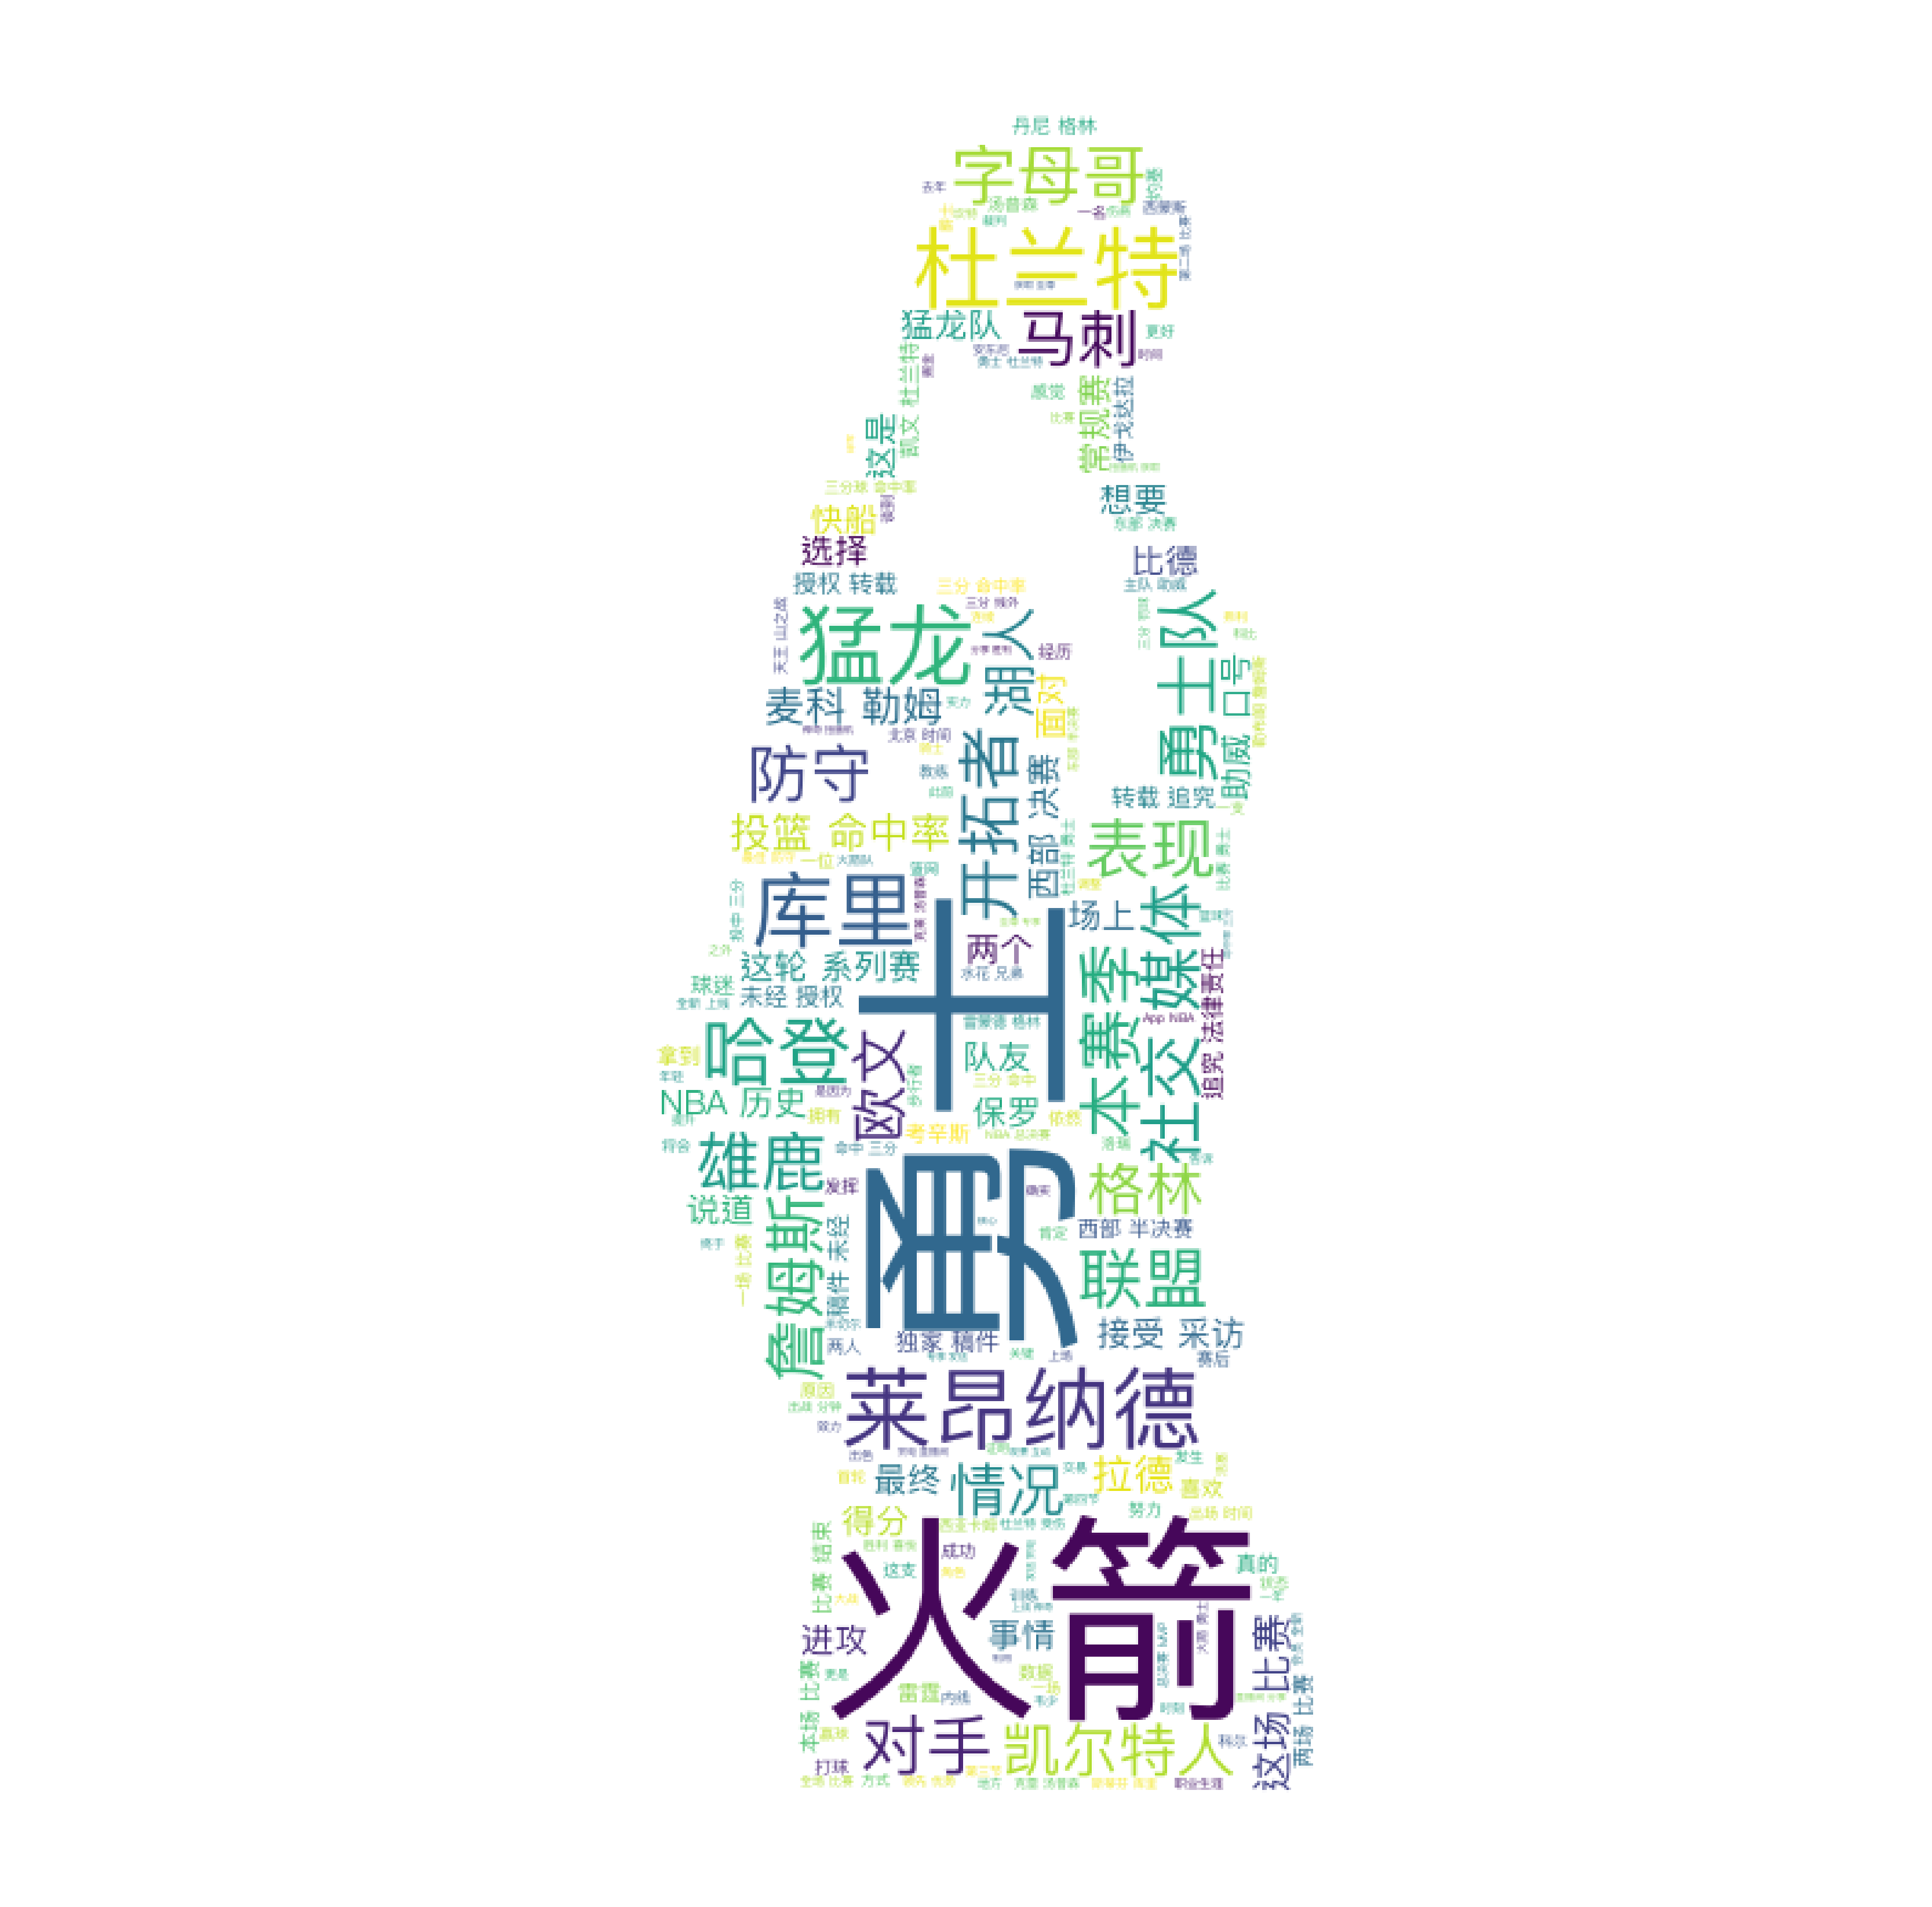

In [453]:
##词云图
def plot_word_cloud():
    """
    plot wordcloud.
    params:
        None.
    return:
        None
    """
    mask = Image.open('./图片/kobe.png') #背景图片格式
    word_cloud = wordcloud.WordCloud(
        font_path = '/System/Library/Fonts/PingFang.ttc', #设置字体格式
        width = 1000,  #设置画布宽度
        height = 1000, #设置画布高度
        stopwords = stop_words,  #设置停用词
        background_color = 'white' , #设置背景颜色
        mask = np.array(mask))  #设定背景形状)
    
    plt.figure(figsize=(8, 8))
    word_cloud.generate(' '.join(df_NBA.seg))  #利用分词结果生成词云图
    plt.imshow(word_cloud)    #画出词云图
    plt.axis('off')   #关闭坐标轴
    plt.savefig('./图片/news_wordcloud.png', dpi = 500, bbox_inches = 'tight')
    plt.show()
    plt.close()

if __name__ == '__main__':
    plot_word_cloud()

- 根据词云图，初步确定2019年NBA季后赛期间，热度最大的球队和球员。
    - 球队有：**勇士、火箭、猛龙、雄鹿、凯尔特人、开拓者**。
    - 球员有：**杜兰特、莱昂纳德、哈登、库里、字母哥、詹姆斯、伊戈达拉、西亚卡姆**。
    + 据此分析各个球队和各个球员在季后赛的热度和关注度，用球队名称和球员名字**词频**和**TF-IDF**值反映热度。

 ---
 #### （3）词频统计

In [153]:
def word_frequence_one_decument(keywords, df):
    """
    输入词语和文档，输出该词在该文档的词频。
    params:
        keywords: the key words needed to count frequence.
        df: data contains segment words.
    return:
        result: the frequence of key words.
    """
    result = []
    df_word_list = [x for x in jieba.lcut(df) if x not in stop_words]
    for word in keywords:
        result.append(df_word_list.count(word))
    return result

if __name__ == '__main__':
    NBA_team = ['勇士', '火箭', '猛龙', '雄鹿', '凯尔特人', '马刺']
    NBA_player = ['杜兰特', '莱昂纳德', '哈登', '库里', '字母哥', '詹姆斯', '伊戈达拉', '西亚卡姆']

    keywords = NBA_team + NBA_player
    NBA_frequence = pd.DataFrame(columns=keywords)
    i = 0
    for content in df_NBA.seg:
        frequence = word_frequence_one_decument(keywords, content)
        NBA_frequence.loc[i, :] = frequence
        i += 1
        
    NBA_frequence['day'] = list(df_NBA.day)
    frequence = NBA_frequence.groupby('day').sum()

+ 在NBA比赛中，通常用比赛周数据来衡量球队和球员近期的战绩和表现。因此，将数据按周进行统计。

In [246]:
def week_average(df):
    """
    对数据进行周平均处理。
    params:
        df: the result of key words frequence.
    return:
        data frame of frequence grouping by weeks.
    """
    week = []
    for i in range(1, int(len(df)/7)+1):
        a = 'week' + str(i)
        for j in range(7):
            week.append(a)
    df['week'] = week
    return df.groupby('week').sum()/7

if __name__ == '__main__':
    Frequence = week_average(frequence)

----
#### （4）TF-IDF

In [398]:
def Tfidf_process(df_NBA, keywords):
    """
    TF-IDF处理.
    params:
        df_NBA: data with segment words.
        keywords: words needed to count tf-idf.
    return:
        NBA_tfidf: data frame of tf-idf about key words.
    """
    tf = TfidfVectorizer()
    result = tf.fit_transform(df_NBA.seg)
    words = tf.get_feature_names()
    weight = result.toarray()

    NBA_tfidf = pd.DataFrame()
    NBA_tfidf['day'] = df_NBA['day']

    for name in keywords:
        arr = []
        for i in range(len(weight)):
            a = weight[i, words.index(name)]
            arr.append(a)
        NBA_tfidf[name] = arr
    return NBA_tfidf

if __name__ == '__main__':
    tfidf = Tfidf_process(df_NBA, keywords).groupby('day').sum()
    Tfidf = week_average(tfidf)

In [248]:
Tfidf

,勇士,火箭,猛龙,雄鹿,凯尔特人,马刺,杜兰特,莱昂纳德,哈登,库里,字母哥,詹姆斯,伊戈达拉,西亚卡姆
week,,,,,,,,,,,,,,
week1,2.327547,1.423010,0.855081,0.869190,1.202447,1.286087,2.116981,0.587746,1.811984,1.184992,0.535914,0.573234,0.208725,0.463271
week2,2.150181,2.360686,0.789617,0.973297,0.808277,1.540101,1.350735,0.602072,2.061799,0.799050,0.715808,0.648361,0.171474,0.212379
week3,2.586508,3.611106,0.933919,1.236573,1.380884,1.095032,1.820194,1.239650,3.384744,1.183344,1.188805,0.857243,0.488476,0.410978
week4,3.965505,4.987544,1.130567,1.241760,1.489623,0.348145,3.383801,1.241637,3.123886,3.115603,0.731413,1.008701,0.831288,0.313093
week5,1.968322,0.959965,1.370784,1.611357,0.564145,0.331336,1.411764,1.588330,0.558008,2.371134,1.262523,0.838463,0.507300,0.265028
week6,2.293254,0.795858,1.810907,1.824469,0.381770,0.229976,1.544973,1.912810,0.407680,1.401845,1.520503,1.133268,0.523190,0.232350
week7,2.632902,0.840204,3.199204,0.887535,0.212104,0.410616,1.629870,2.851256,0.532597,1.682873,0.723491,1.114428,0.580171,1.153896
week8,3.827524,0.483125,3.538384,0.218465,0.320558,0.365668,1.843094,2.266206,0.114416,2.926030,0.185401,1.069098,1.109130,0.714205
week9,4.198092,0.491102,3.521942,0.257128,0.358270,0.720895,5.656708,2.520397,0.166255,1.707384,0.038744,0.622539,0.520391,0.431731


---
#### （5）词频、TD-IDF分析

#### 球队

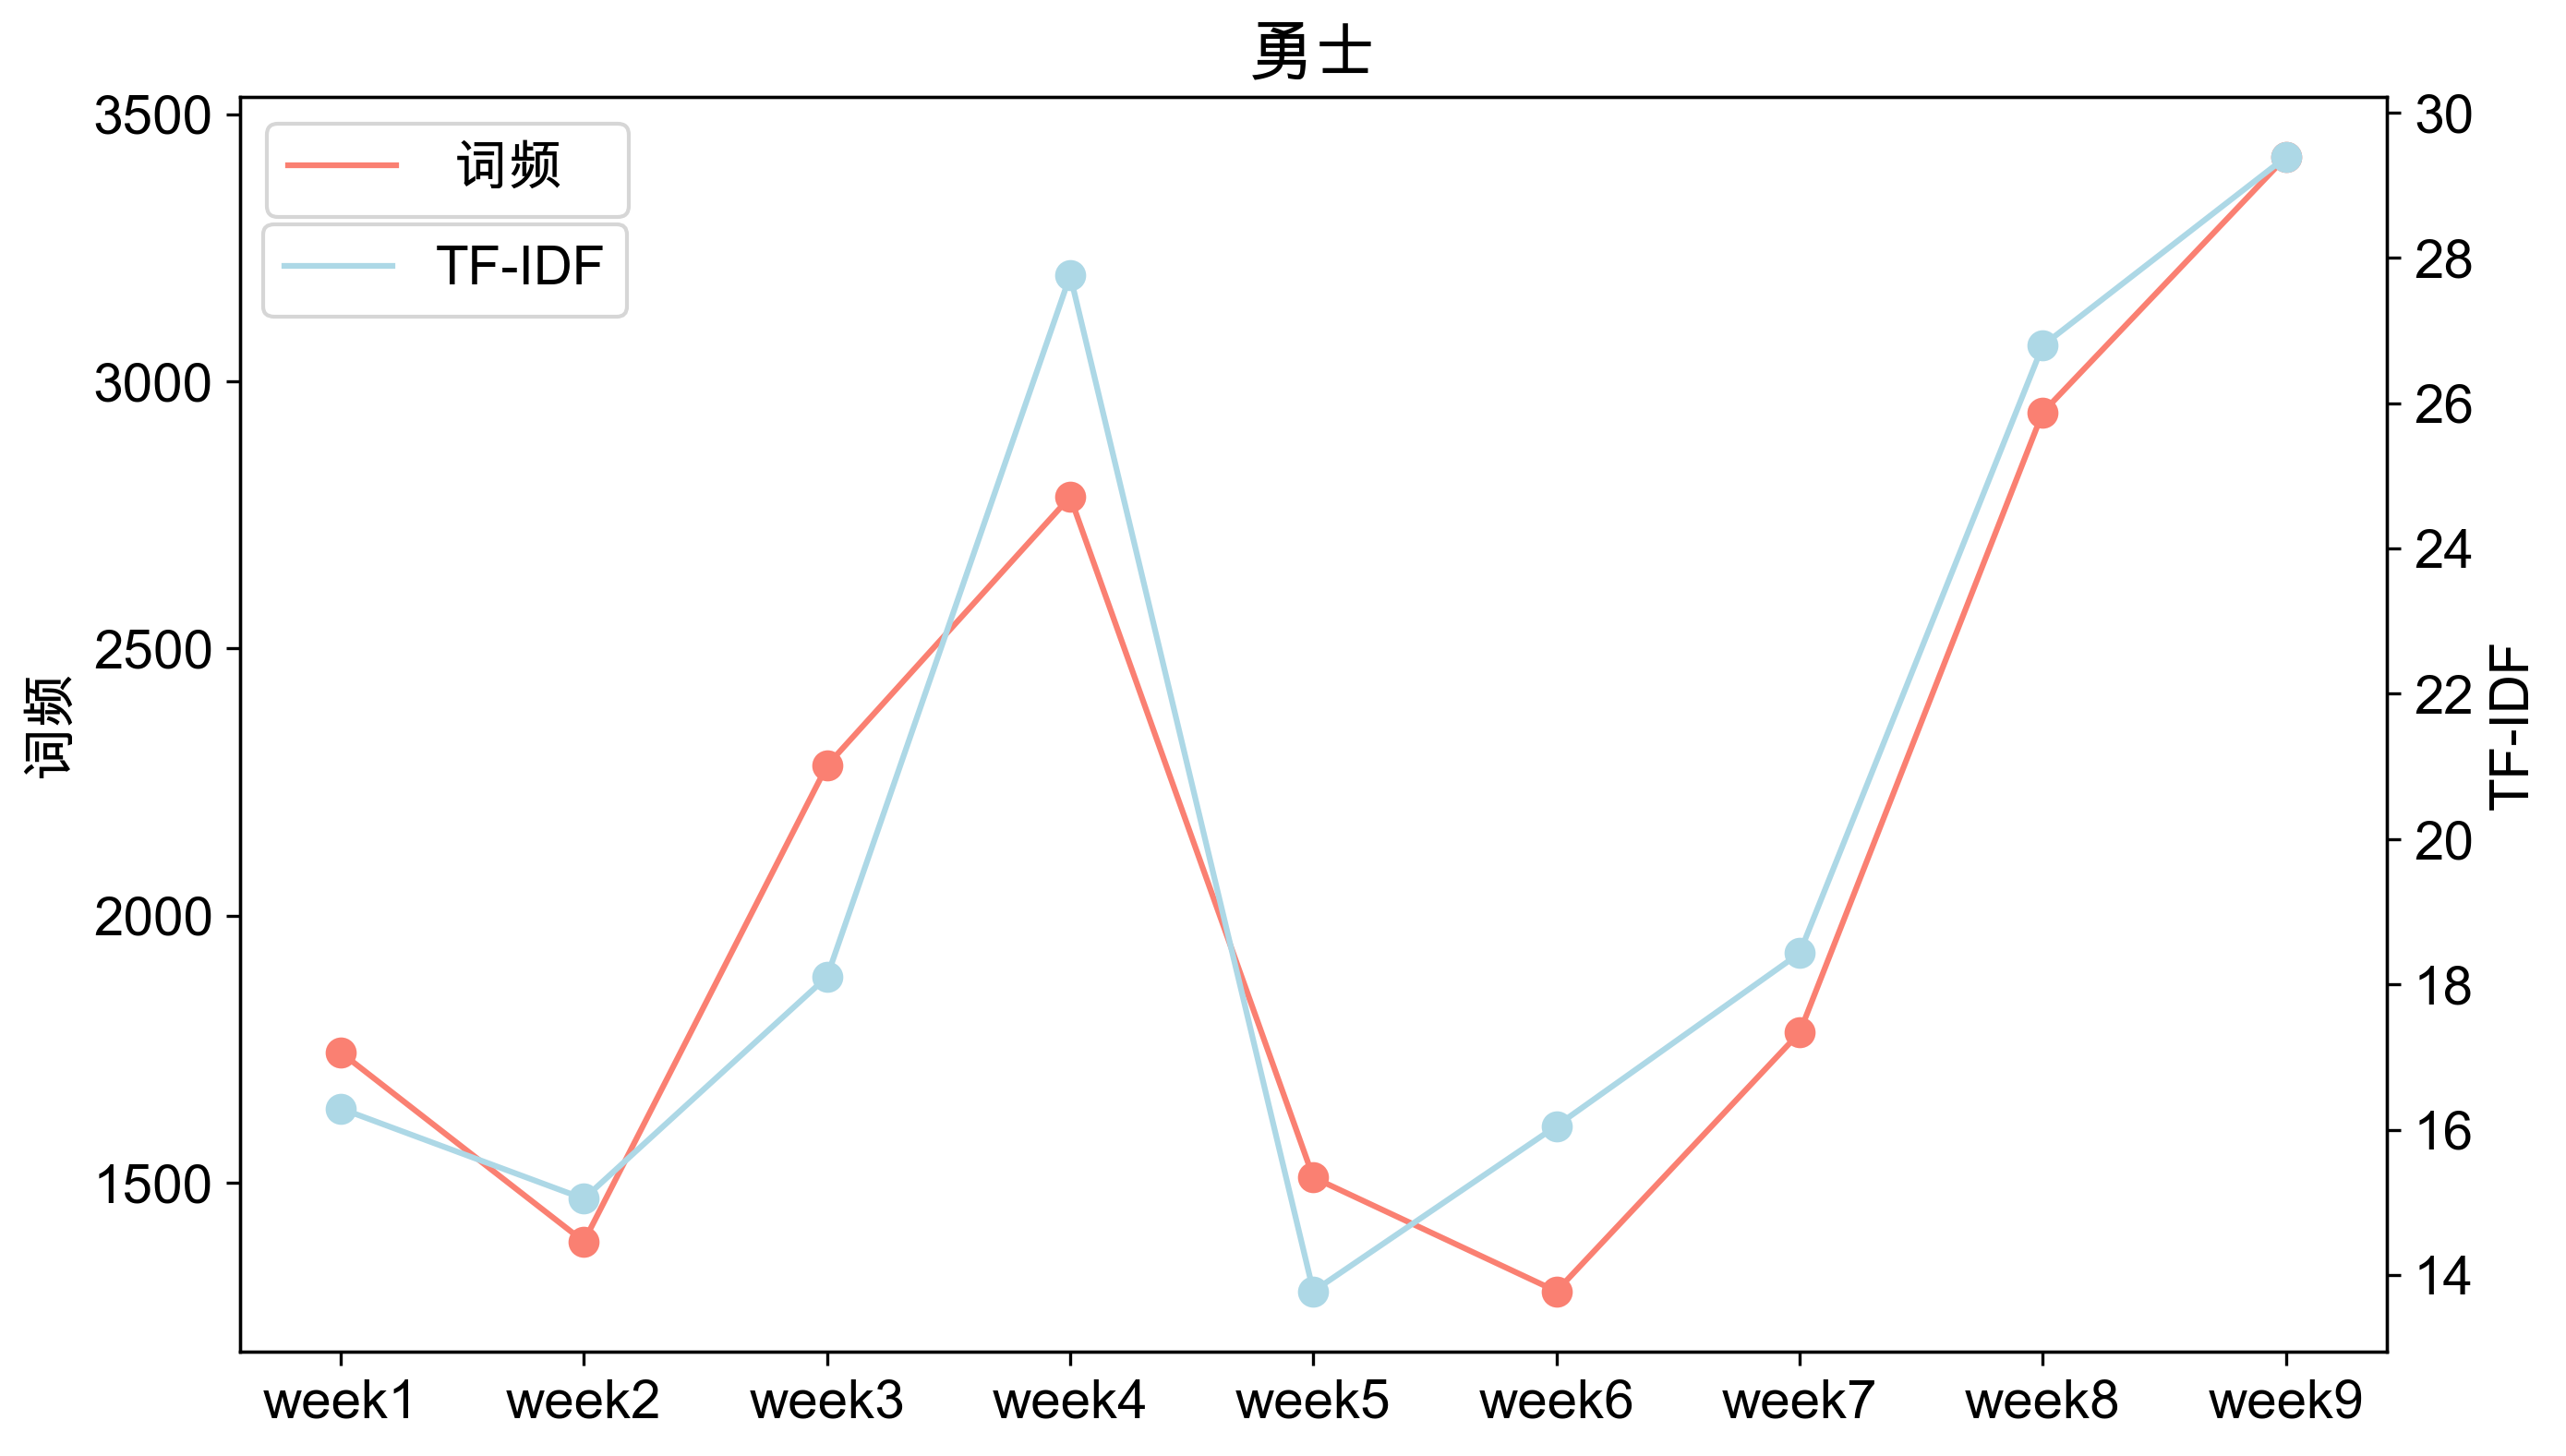

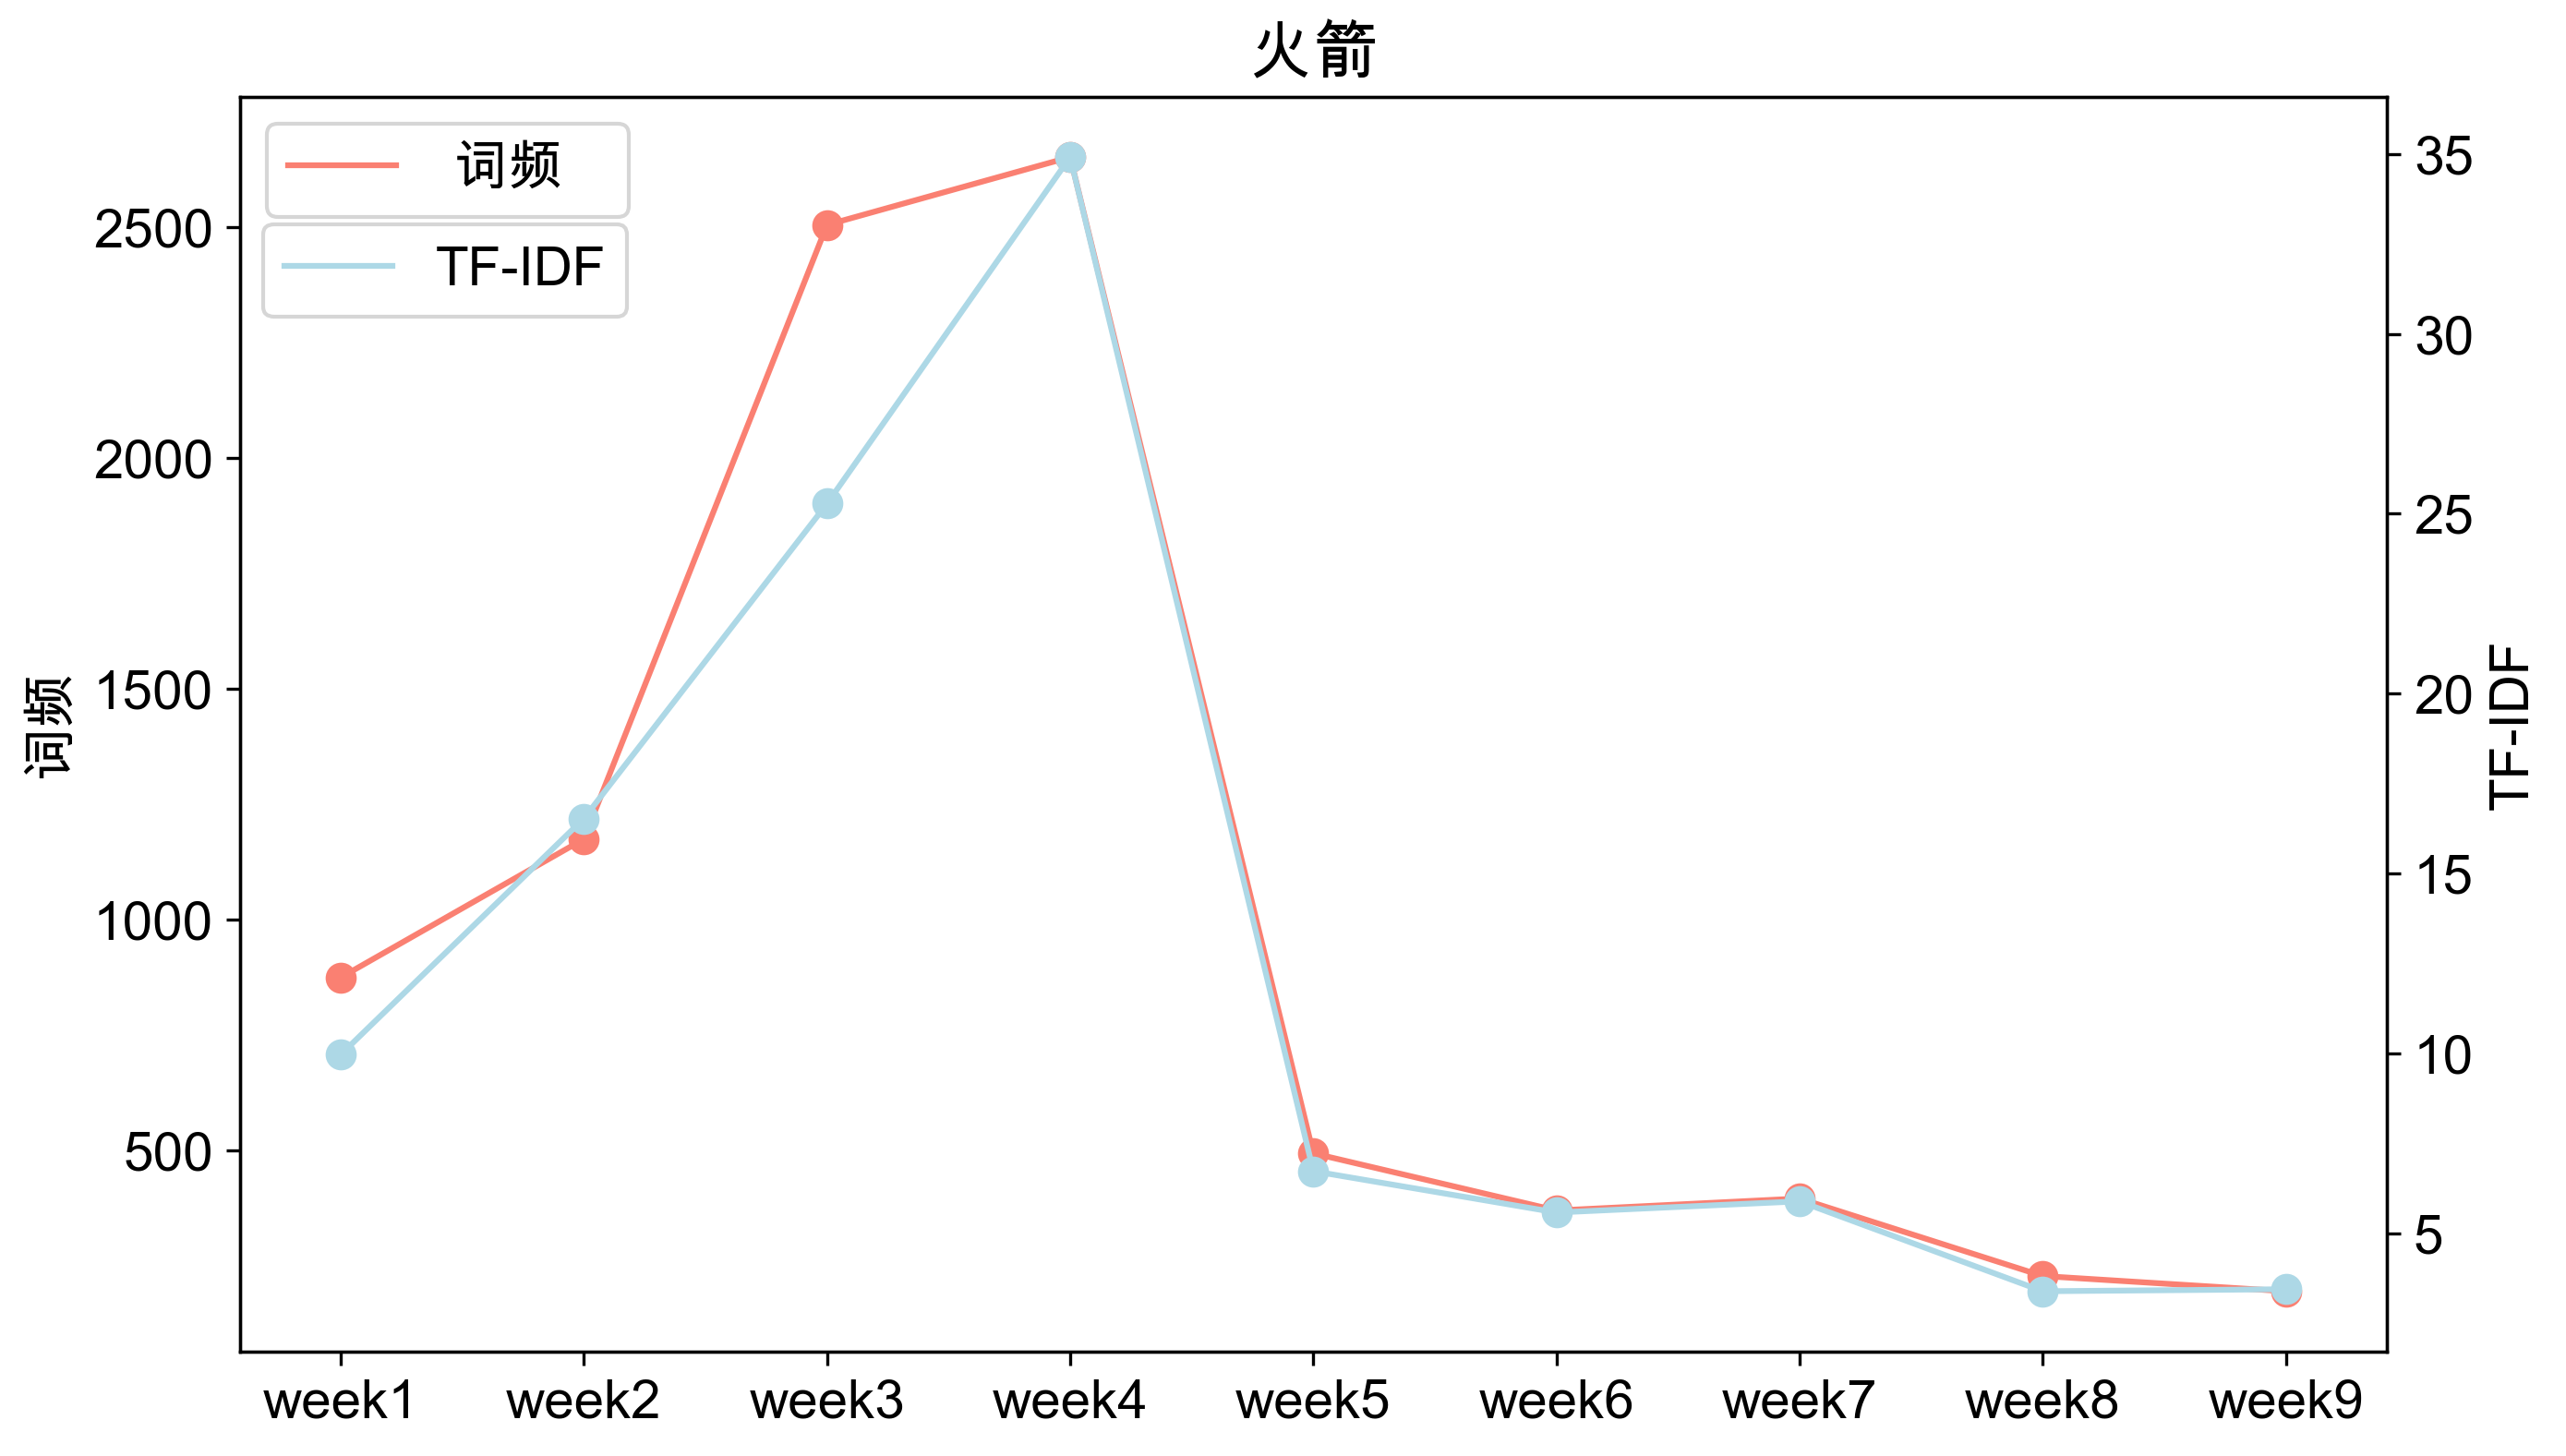

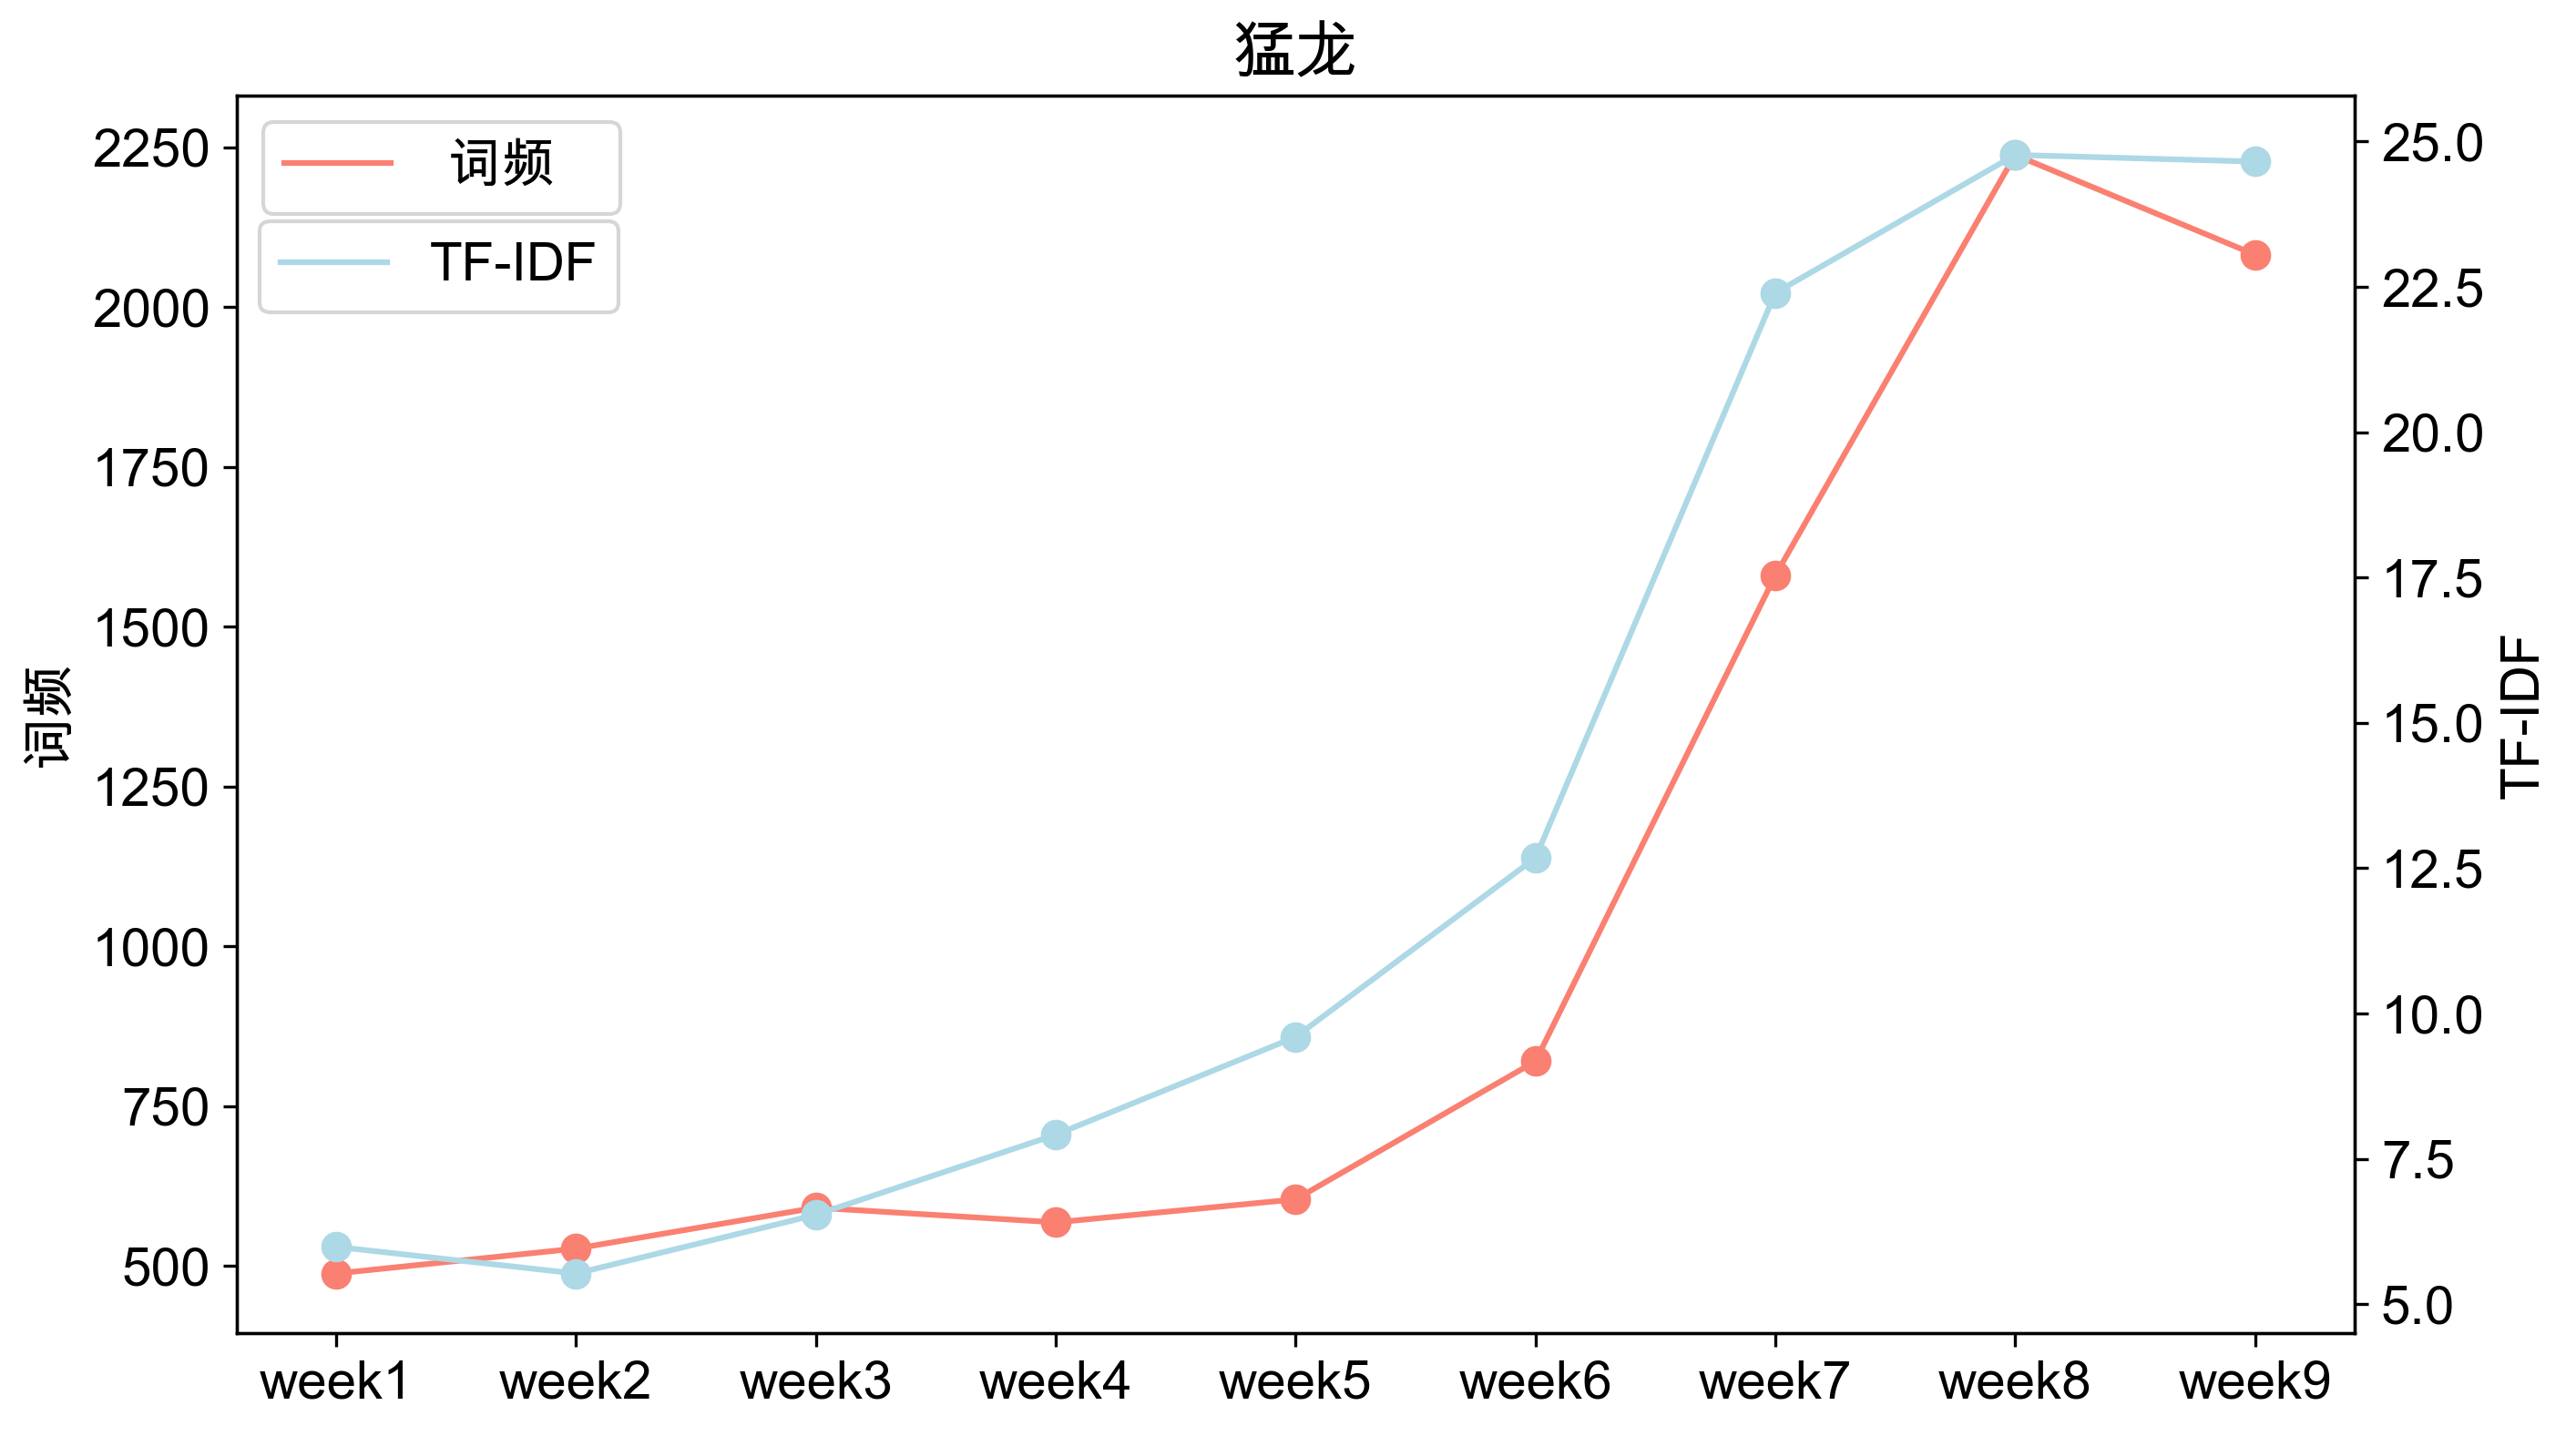

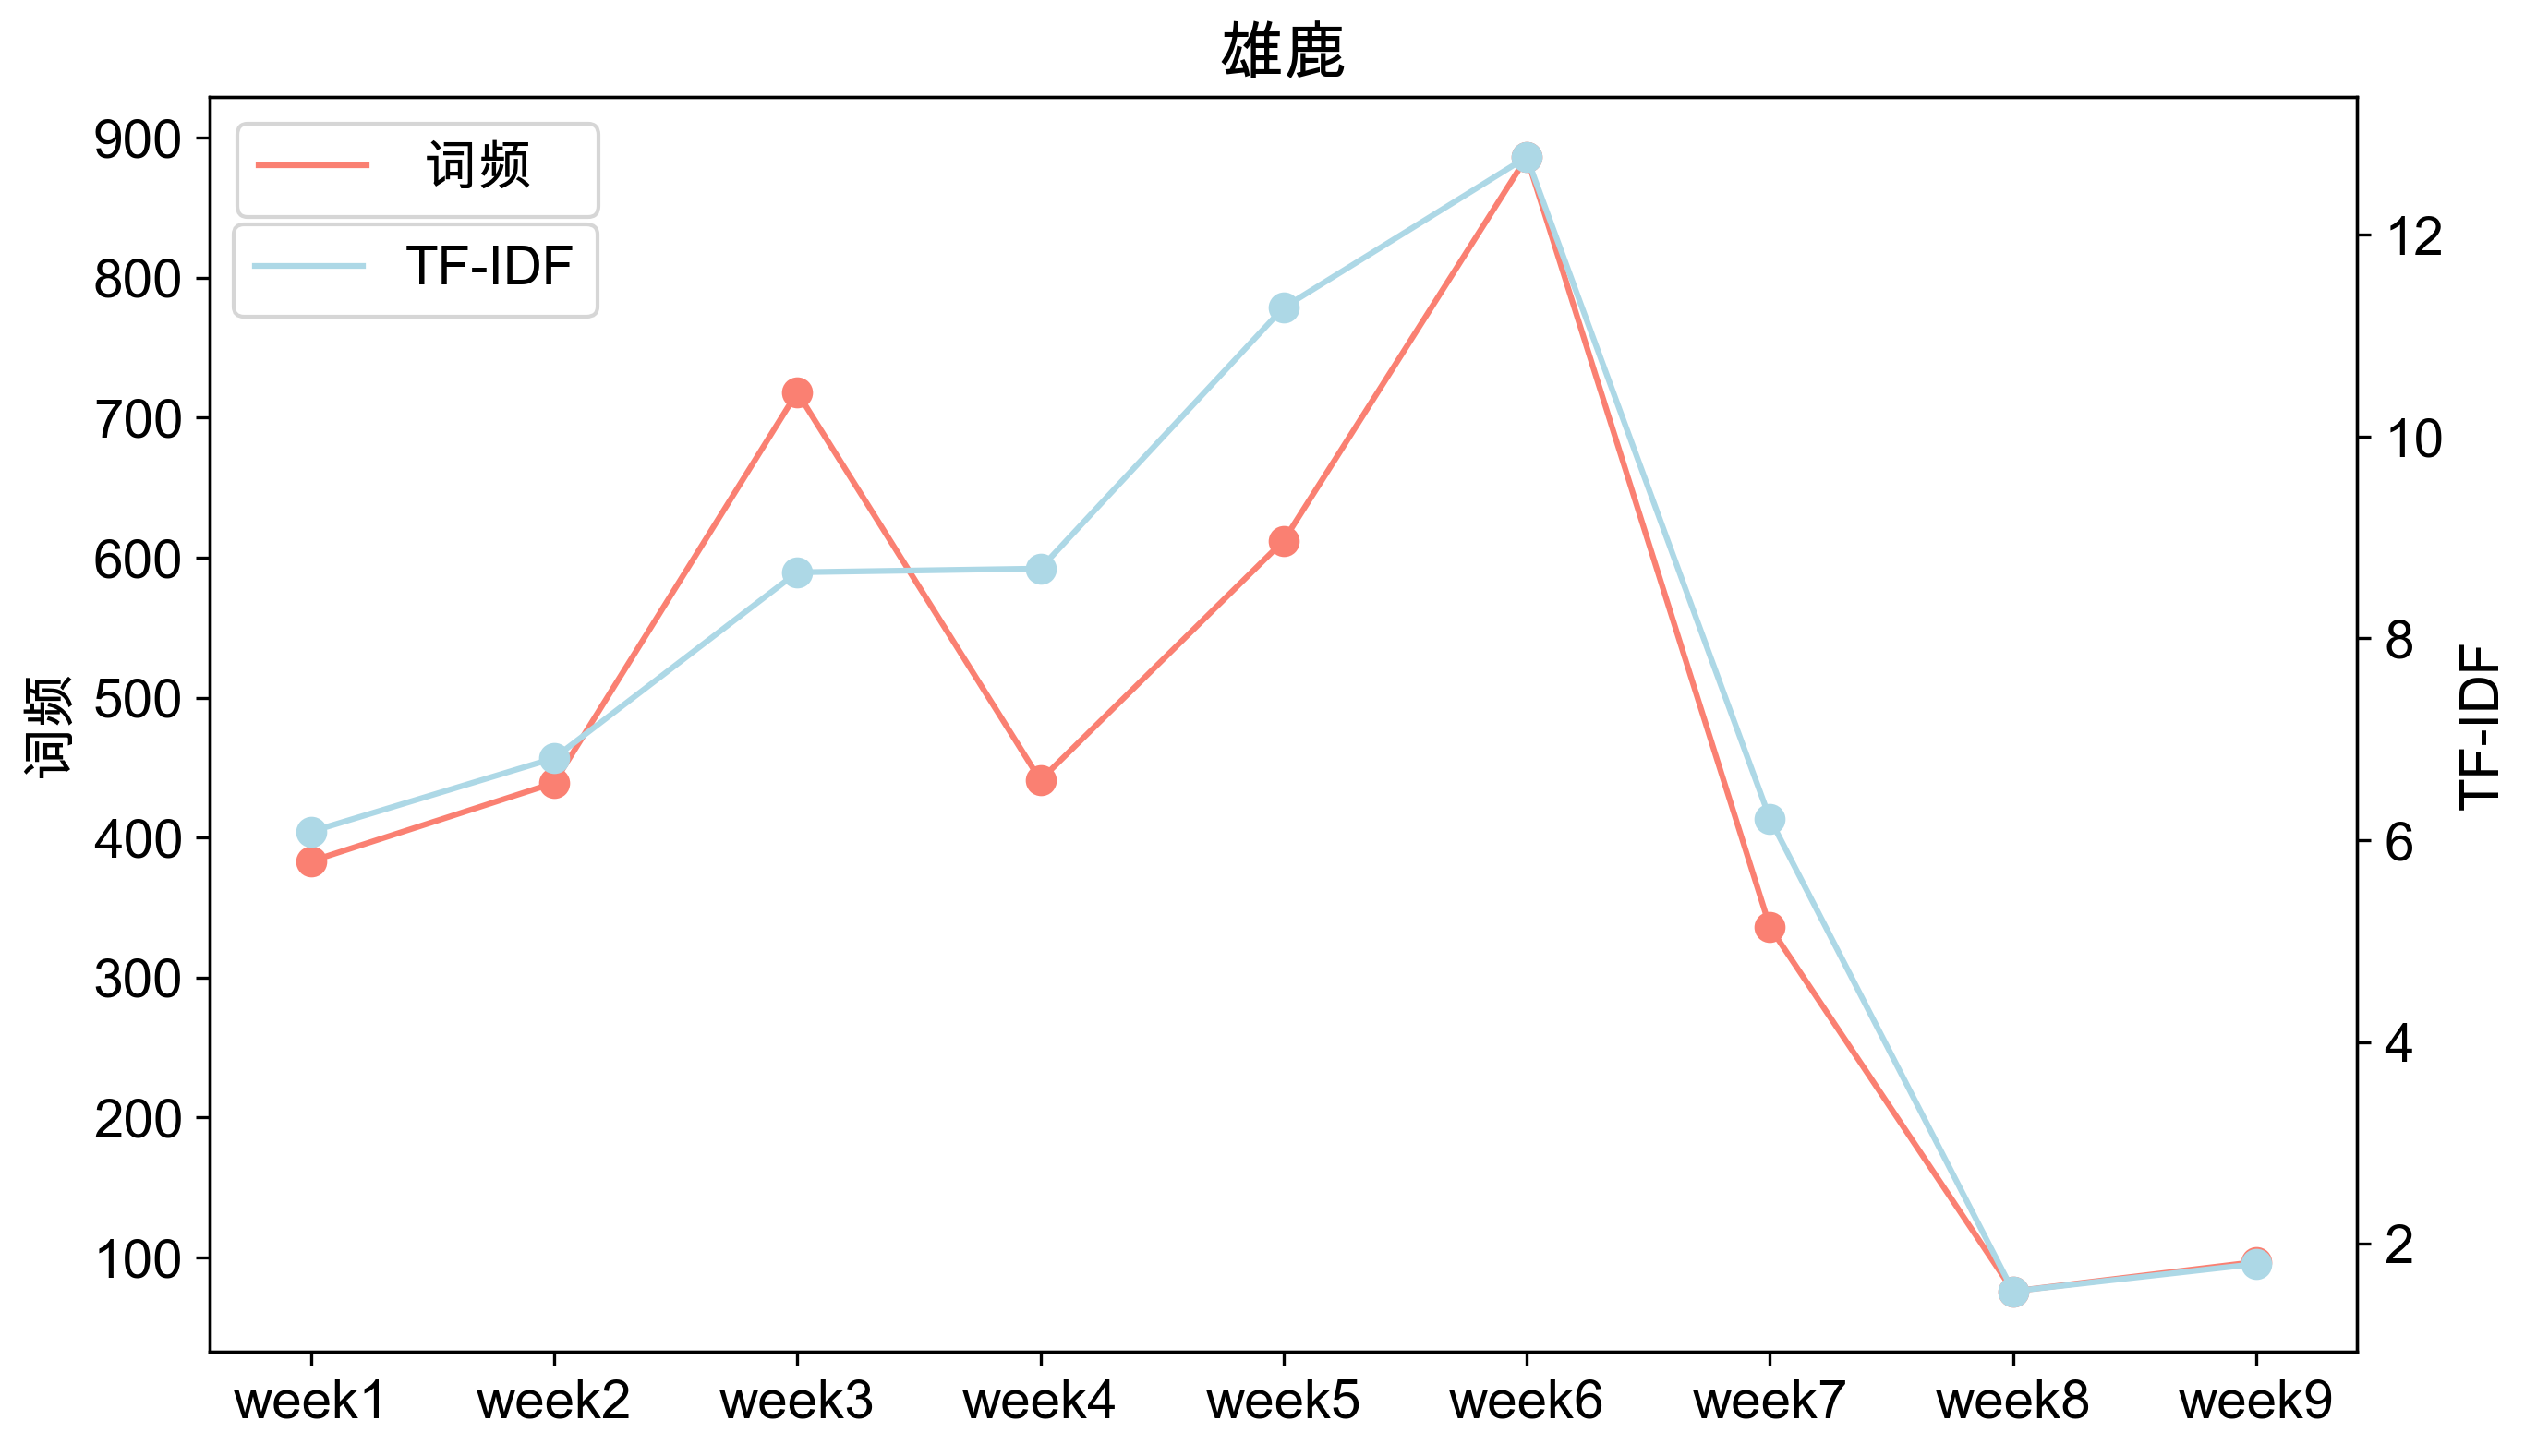

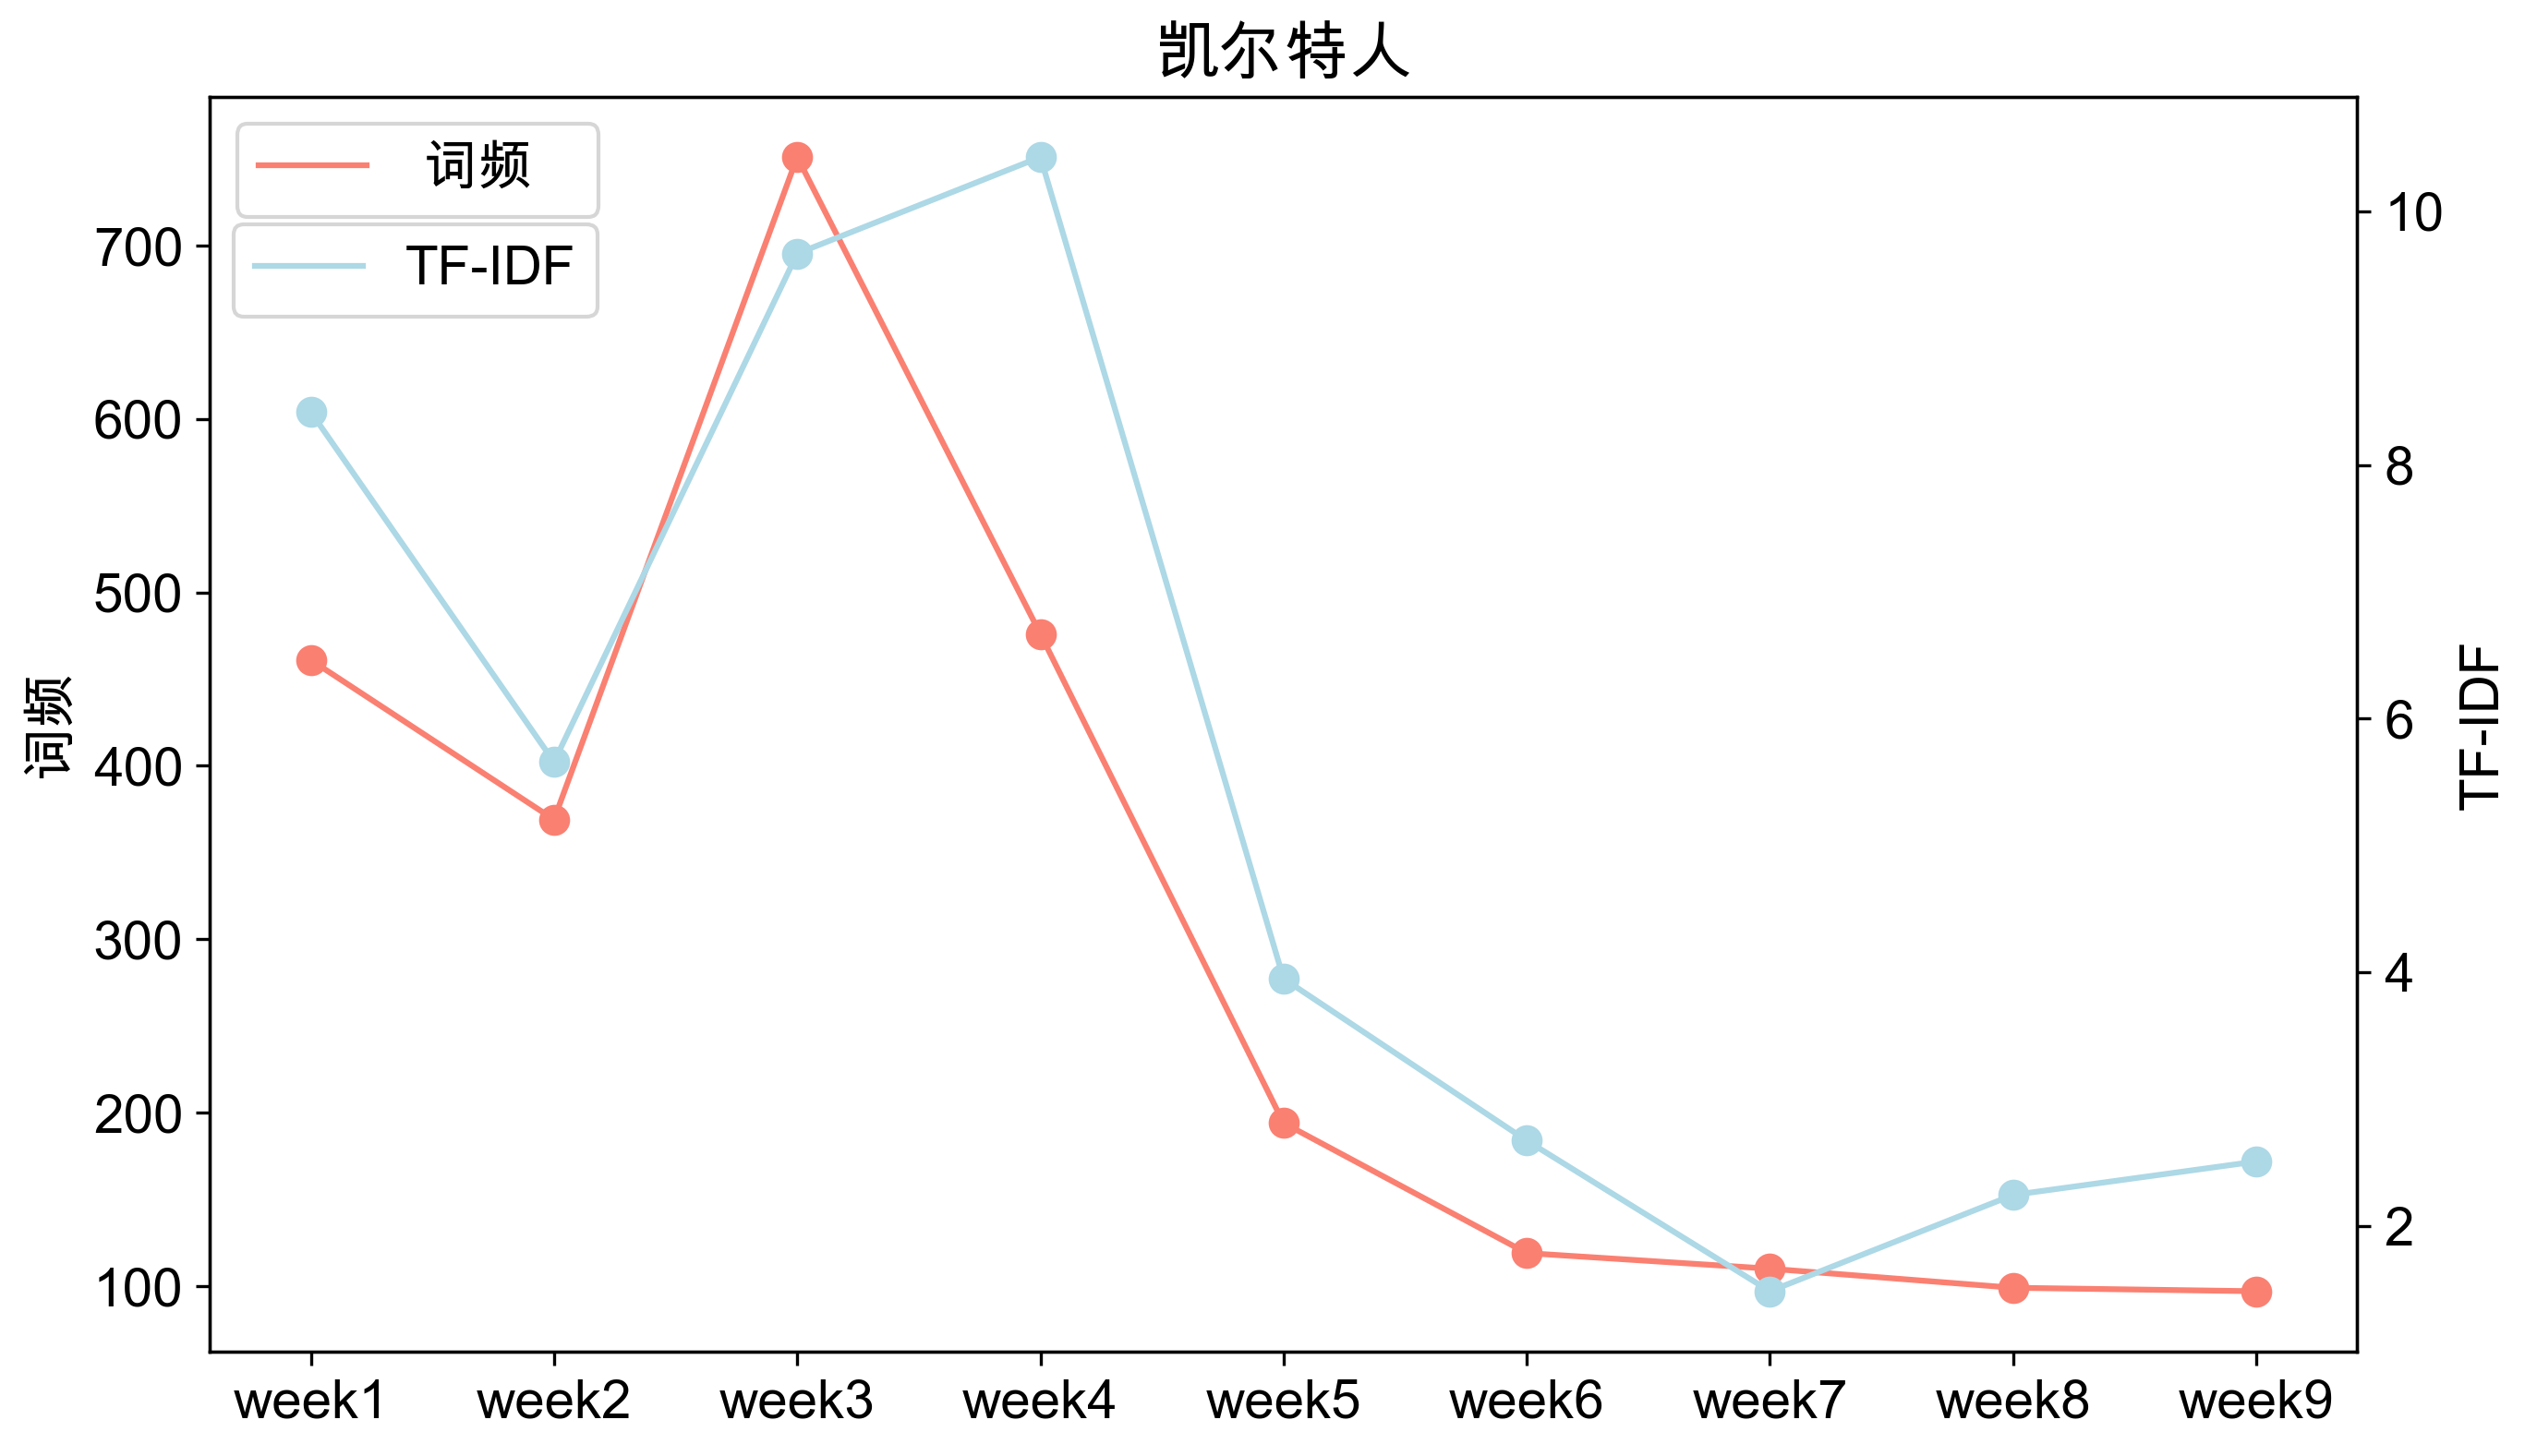

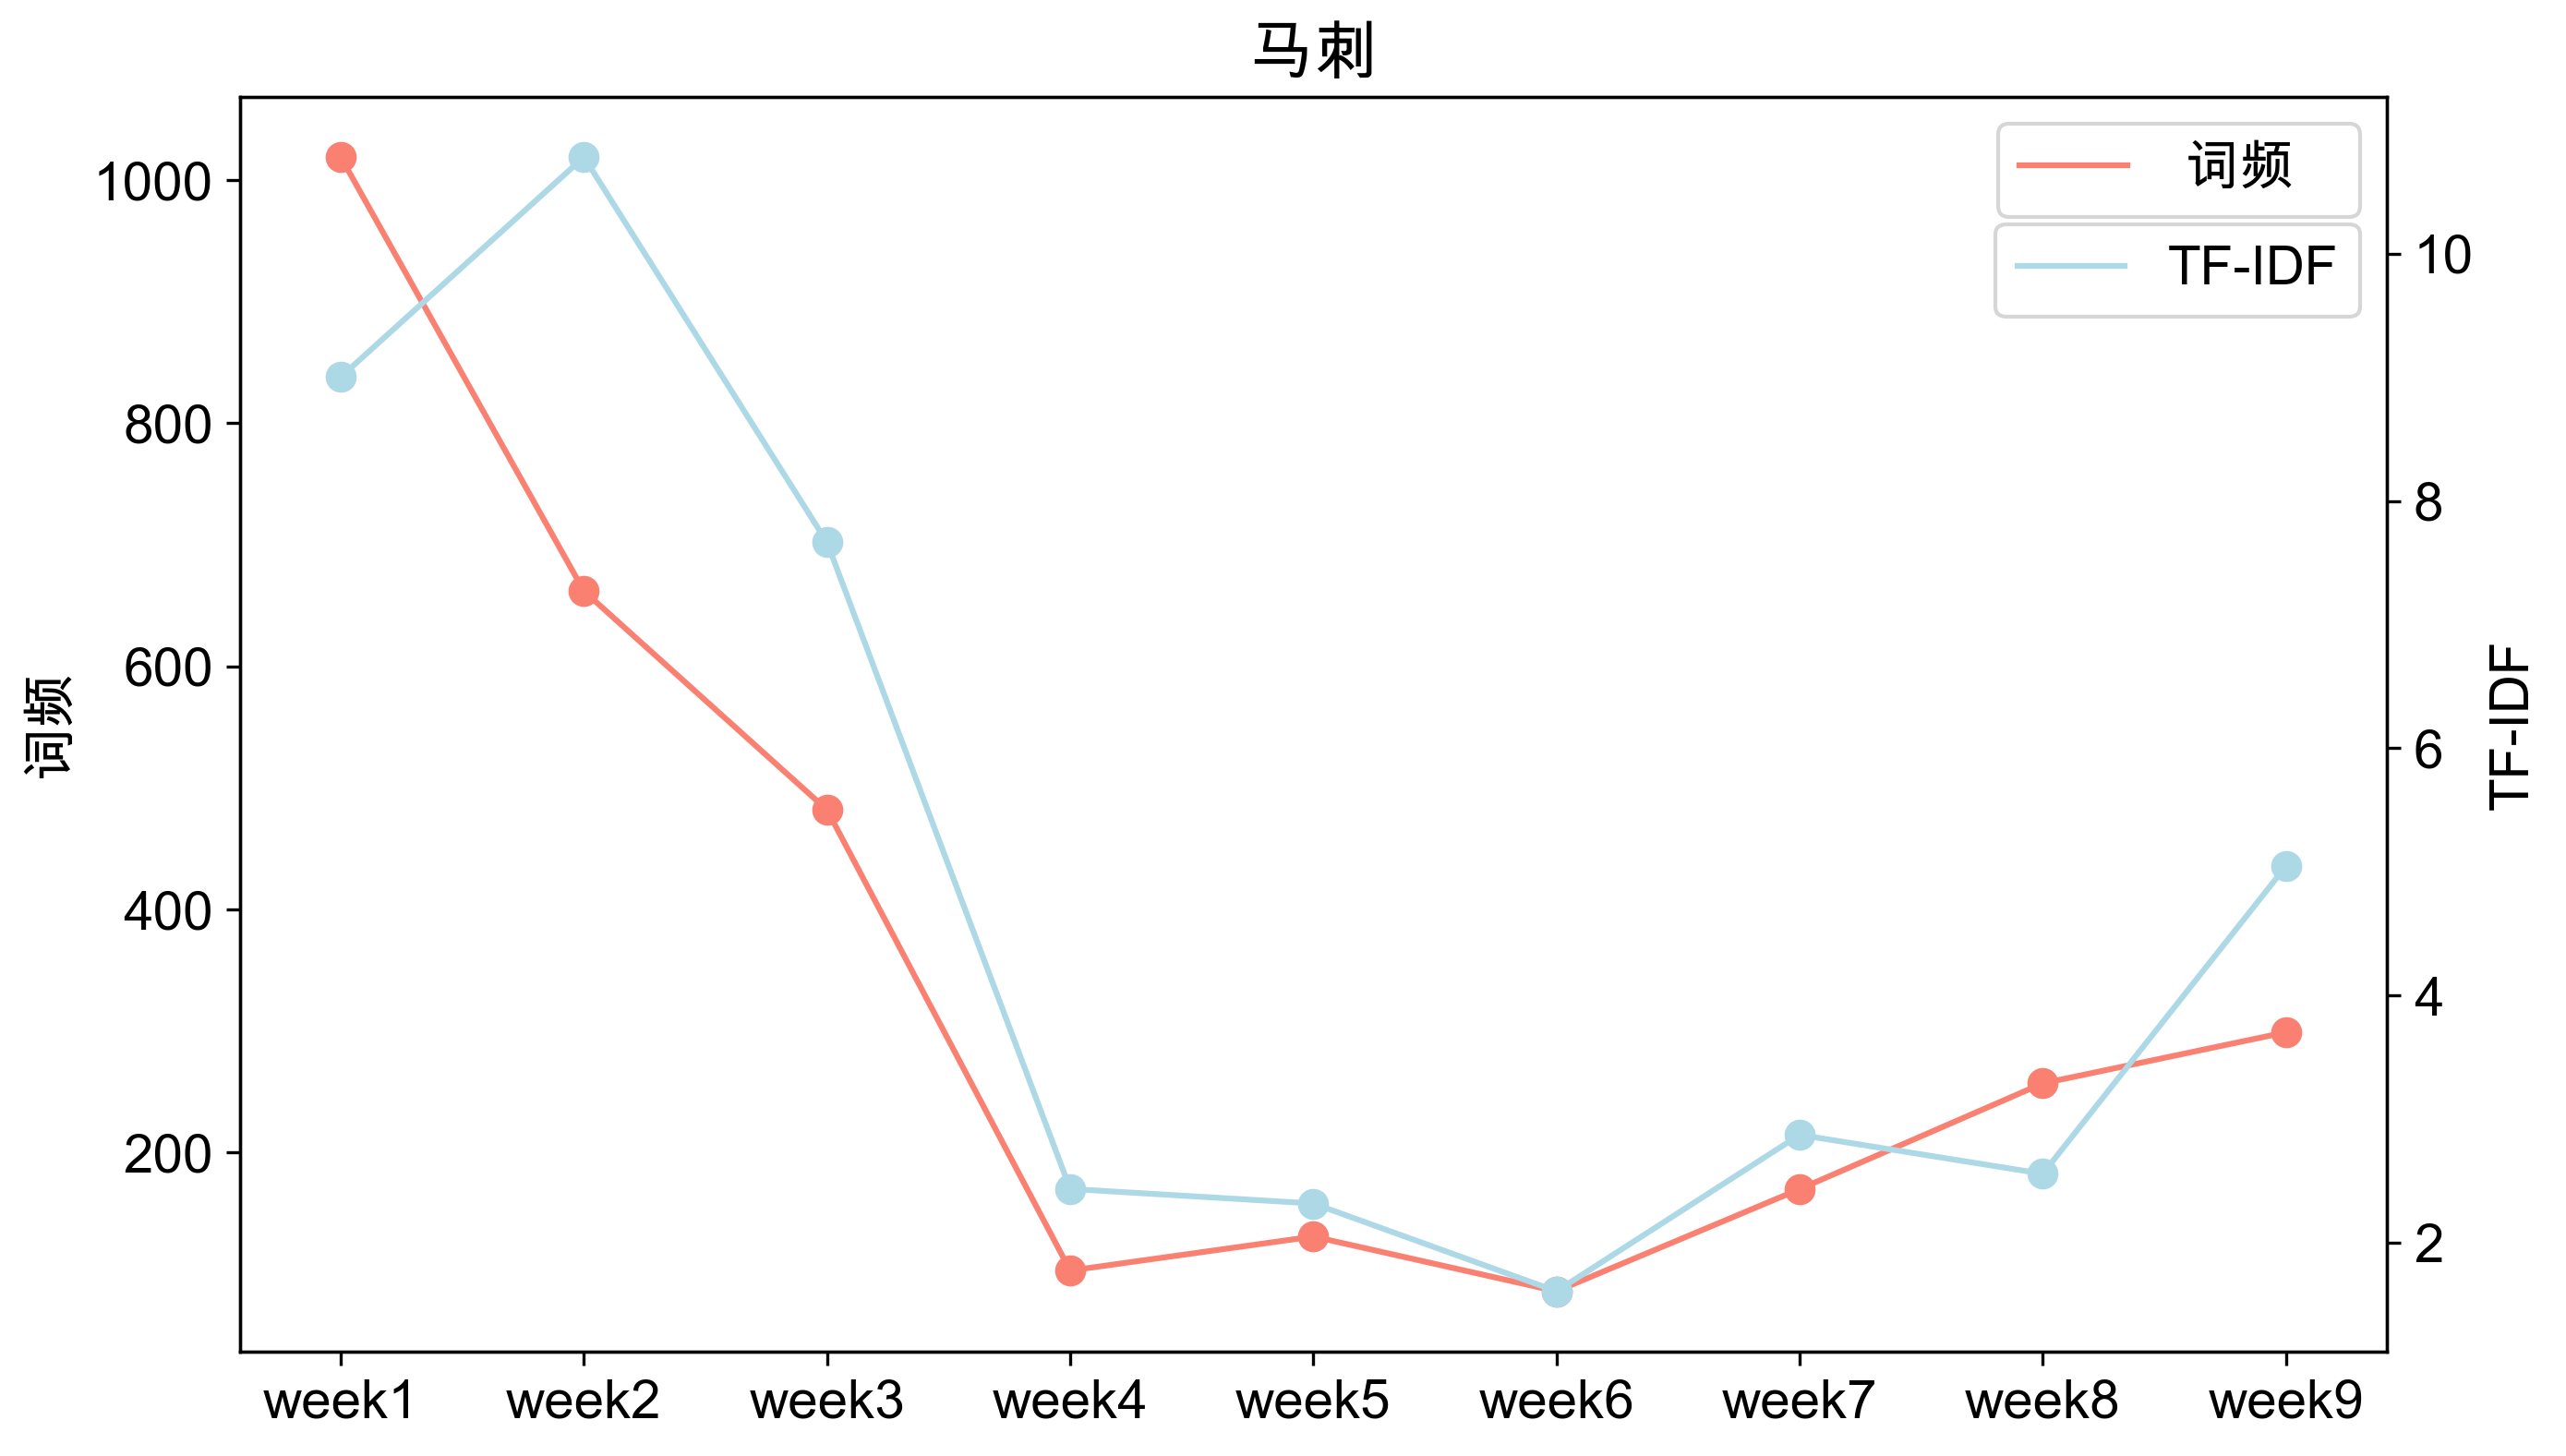

In [57]:
def plot_frequence_tfidf(name, Frequence, Tfidf, c = ['salmon', 'lightblue'], s = 50, loc='upper left', bbox_to_anchor=(0.193, 0.92)):
    """
    plot graph of each key words.
    """
    plt.rc('font', size = 14, family="Arial Unicode MS")
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    x =Frequence.index.tolist()

    l1 = ax.plot(x, Frequence[name], c = c[0])
    ax.scatter(x, Frequence[name], c  = c[0], s = s)
    ax.set_ylabel('词频')
    plt.xticks(rotation = 0)
    ax.legend([' 词频   '], loc = loc)

    ax2 = ax.twinx()
    l2 = ax2.plot(x, Tfidf[name], c = c[1])
    ax2.scatter(x, Tfidf[name], c = c[1], s = s)
    ax2.set_ylabel('TF-IDF')
    ax2.legend(['TF-IDF'], bbox_to_anchor=bbox_to_anchor)
    plt.title(name)
    
    plt.savefig('./PDF报告/%s.png'%(name), dpi = 500, bbox_inches = 'tight')
    plt.show()
    plt.close()
if __name__ == '__main__':
    for name in NBA_team:
        if name == '马刺':
            plot_frequence_tfidf(name, Frequence, Tfidf, loc='upper righr', bbox_to_anchor=(1, 0.92))
        else:
            plot_frequence_tfidf(name, Frequence, Tfidf)

+ **结果分析**：从球队数据的词频和TF-IDF可以看出，勇士队在季后赛比赛周中，第4周和第9周出现两次波峰

---
#### 球员

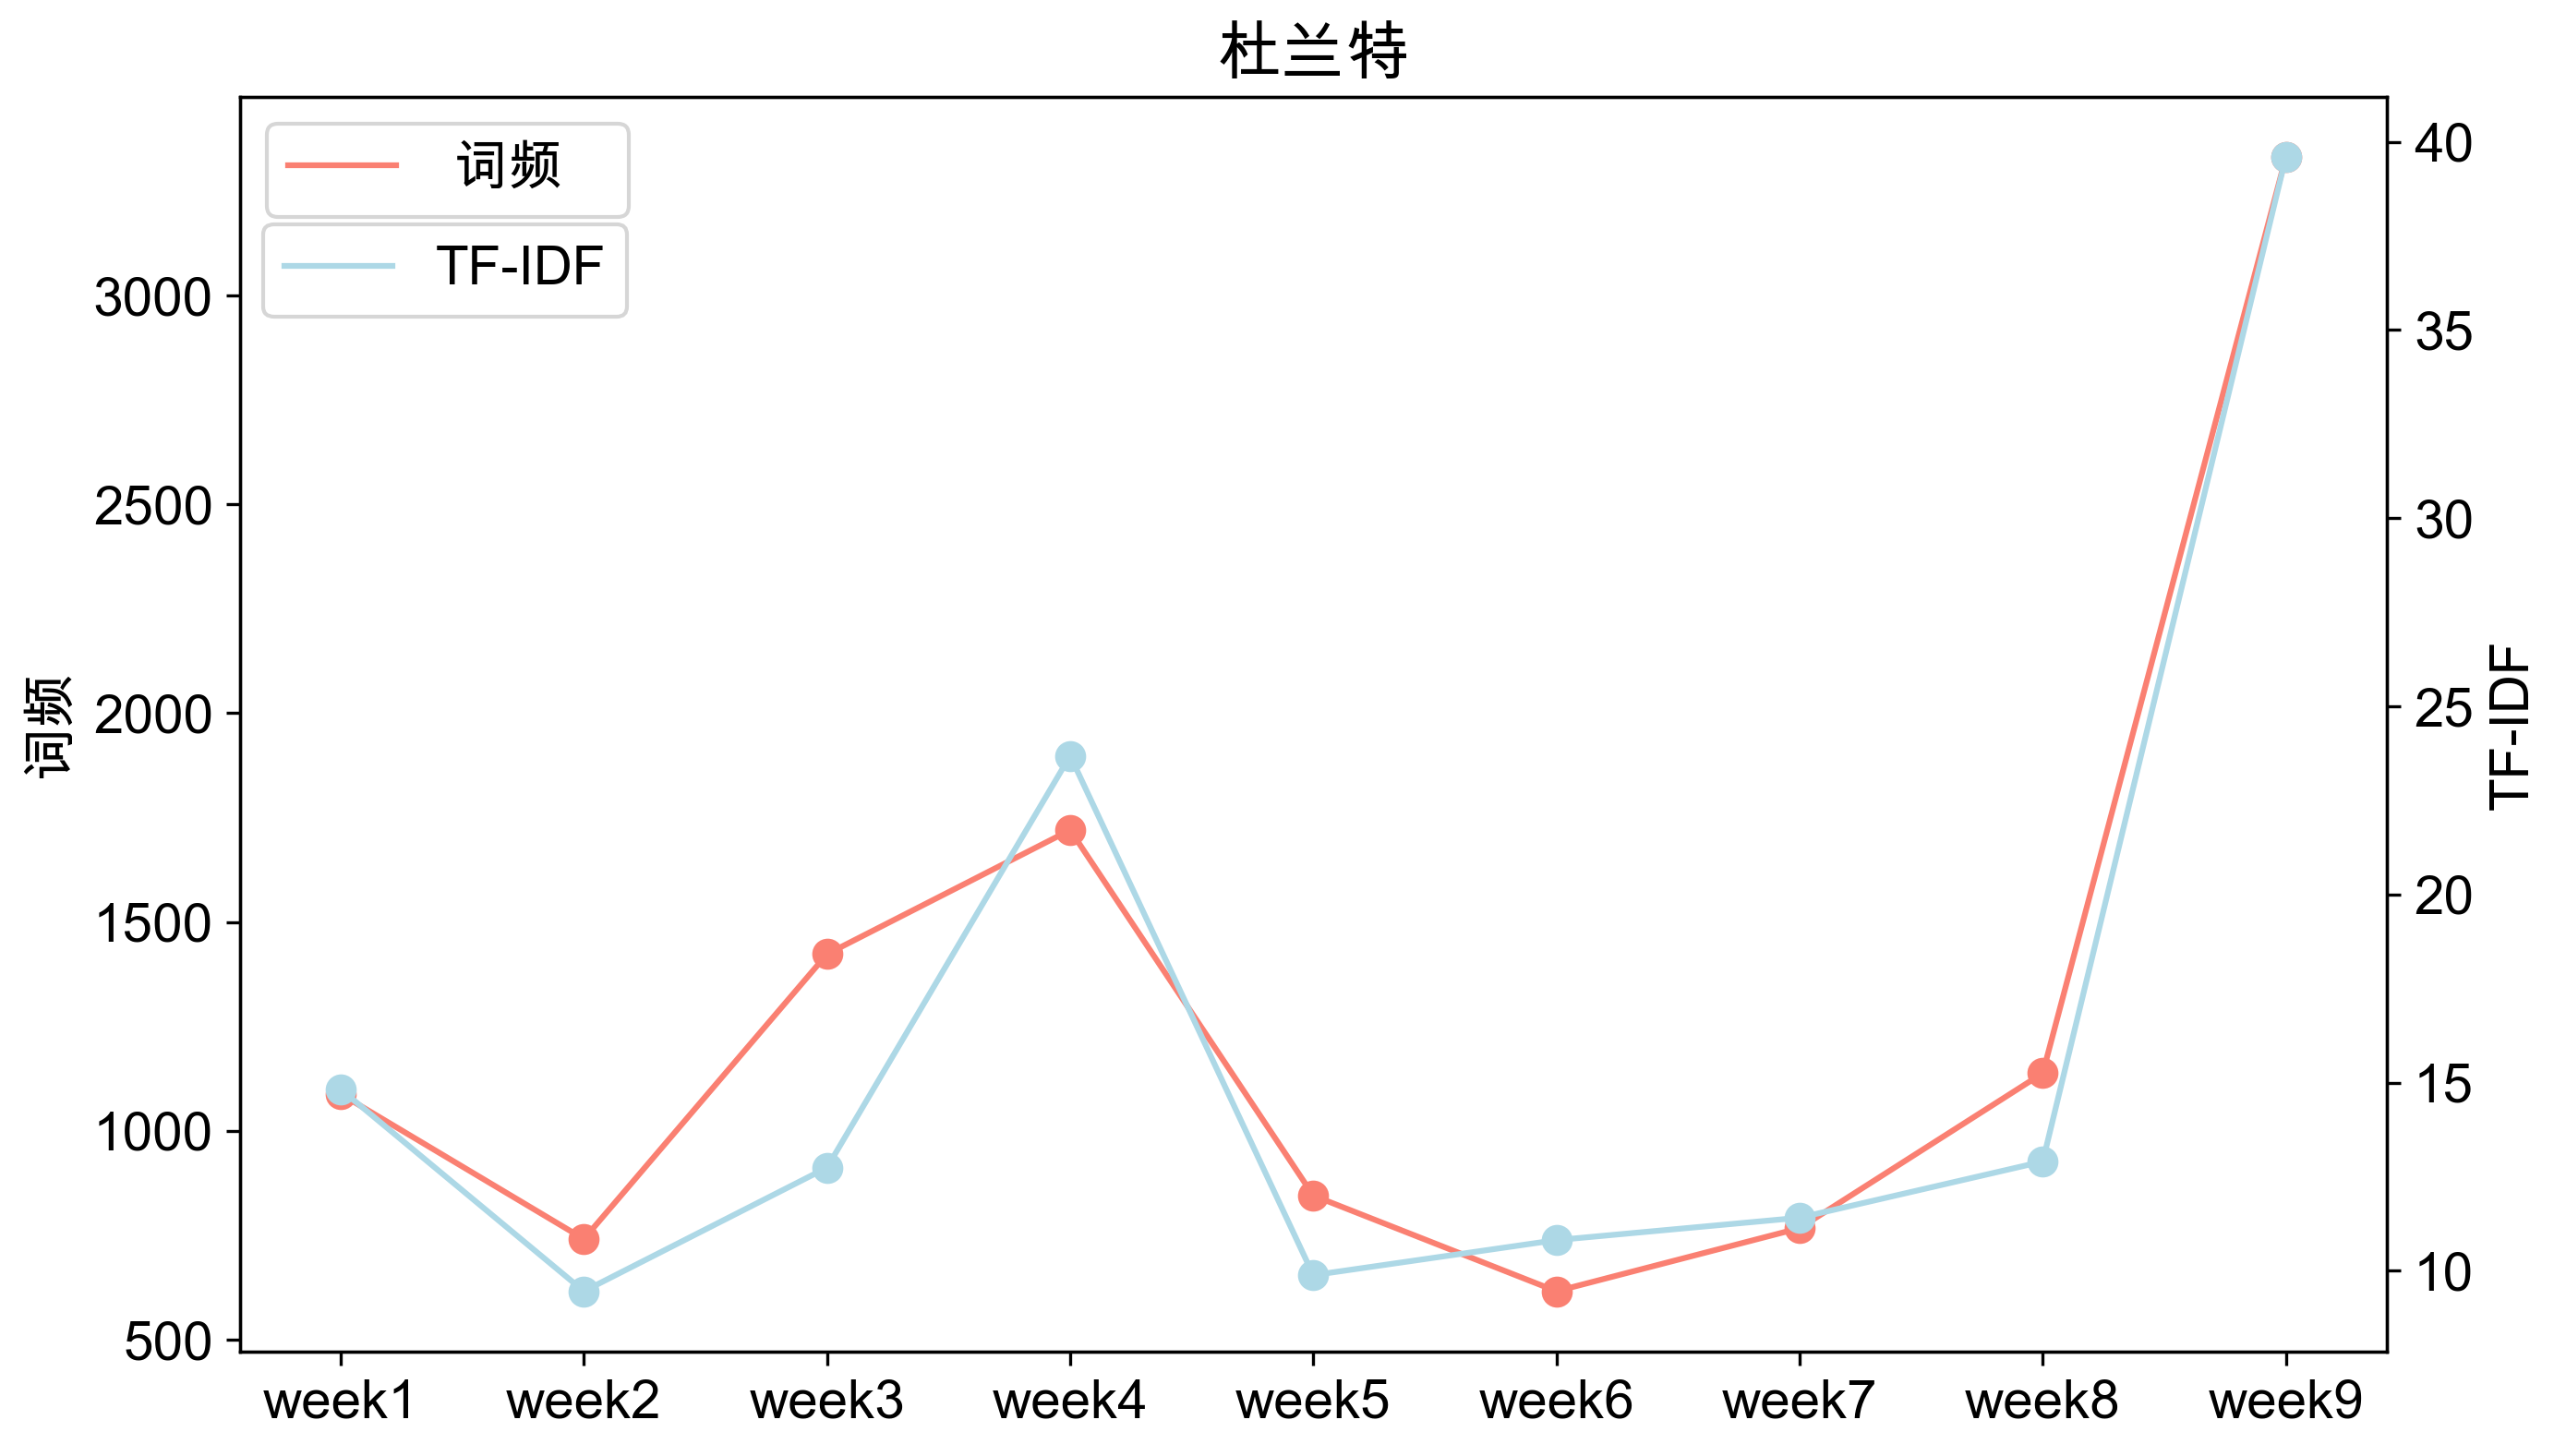

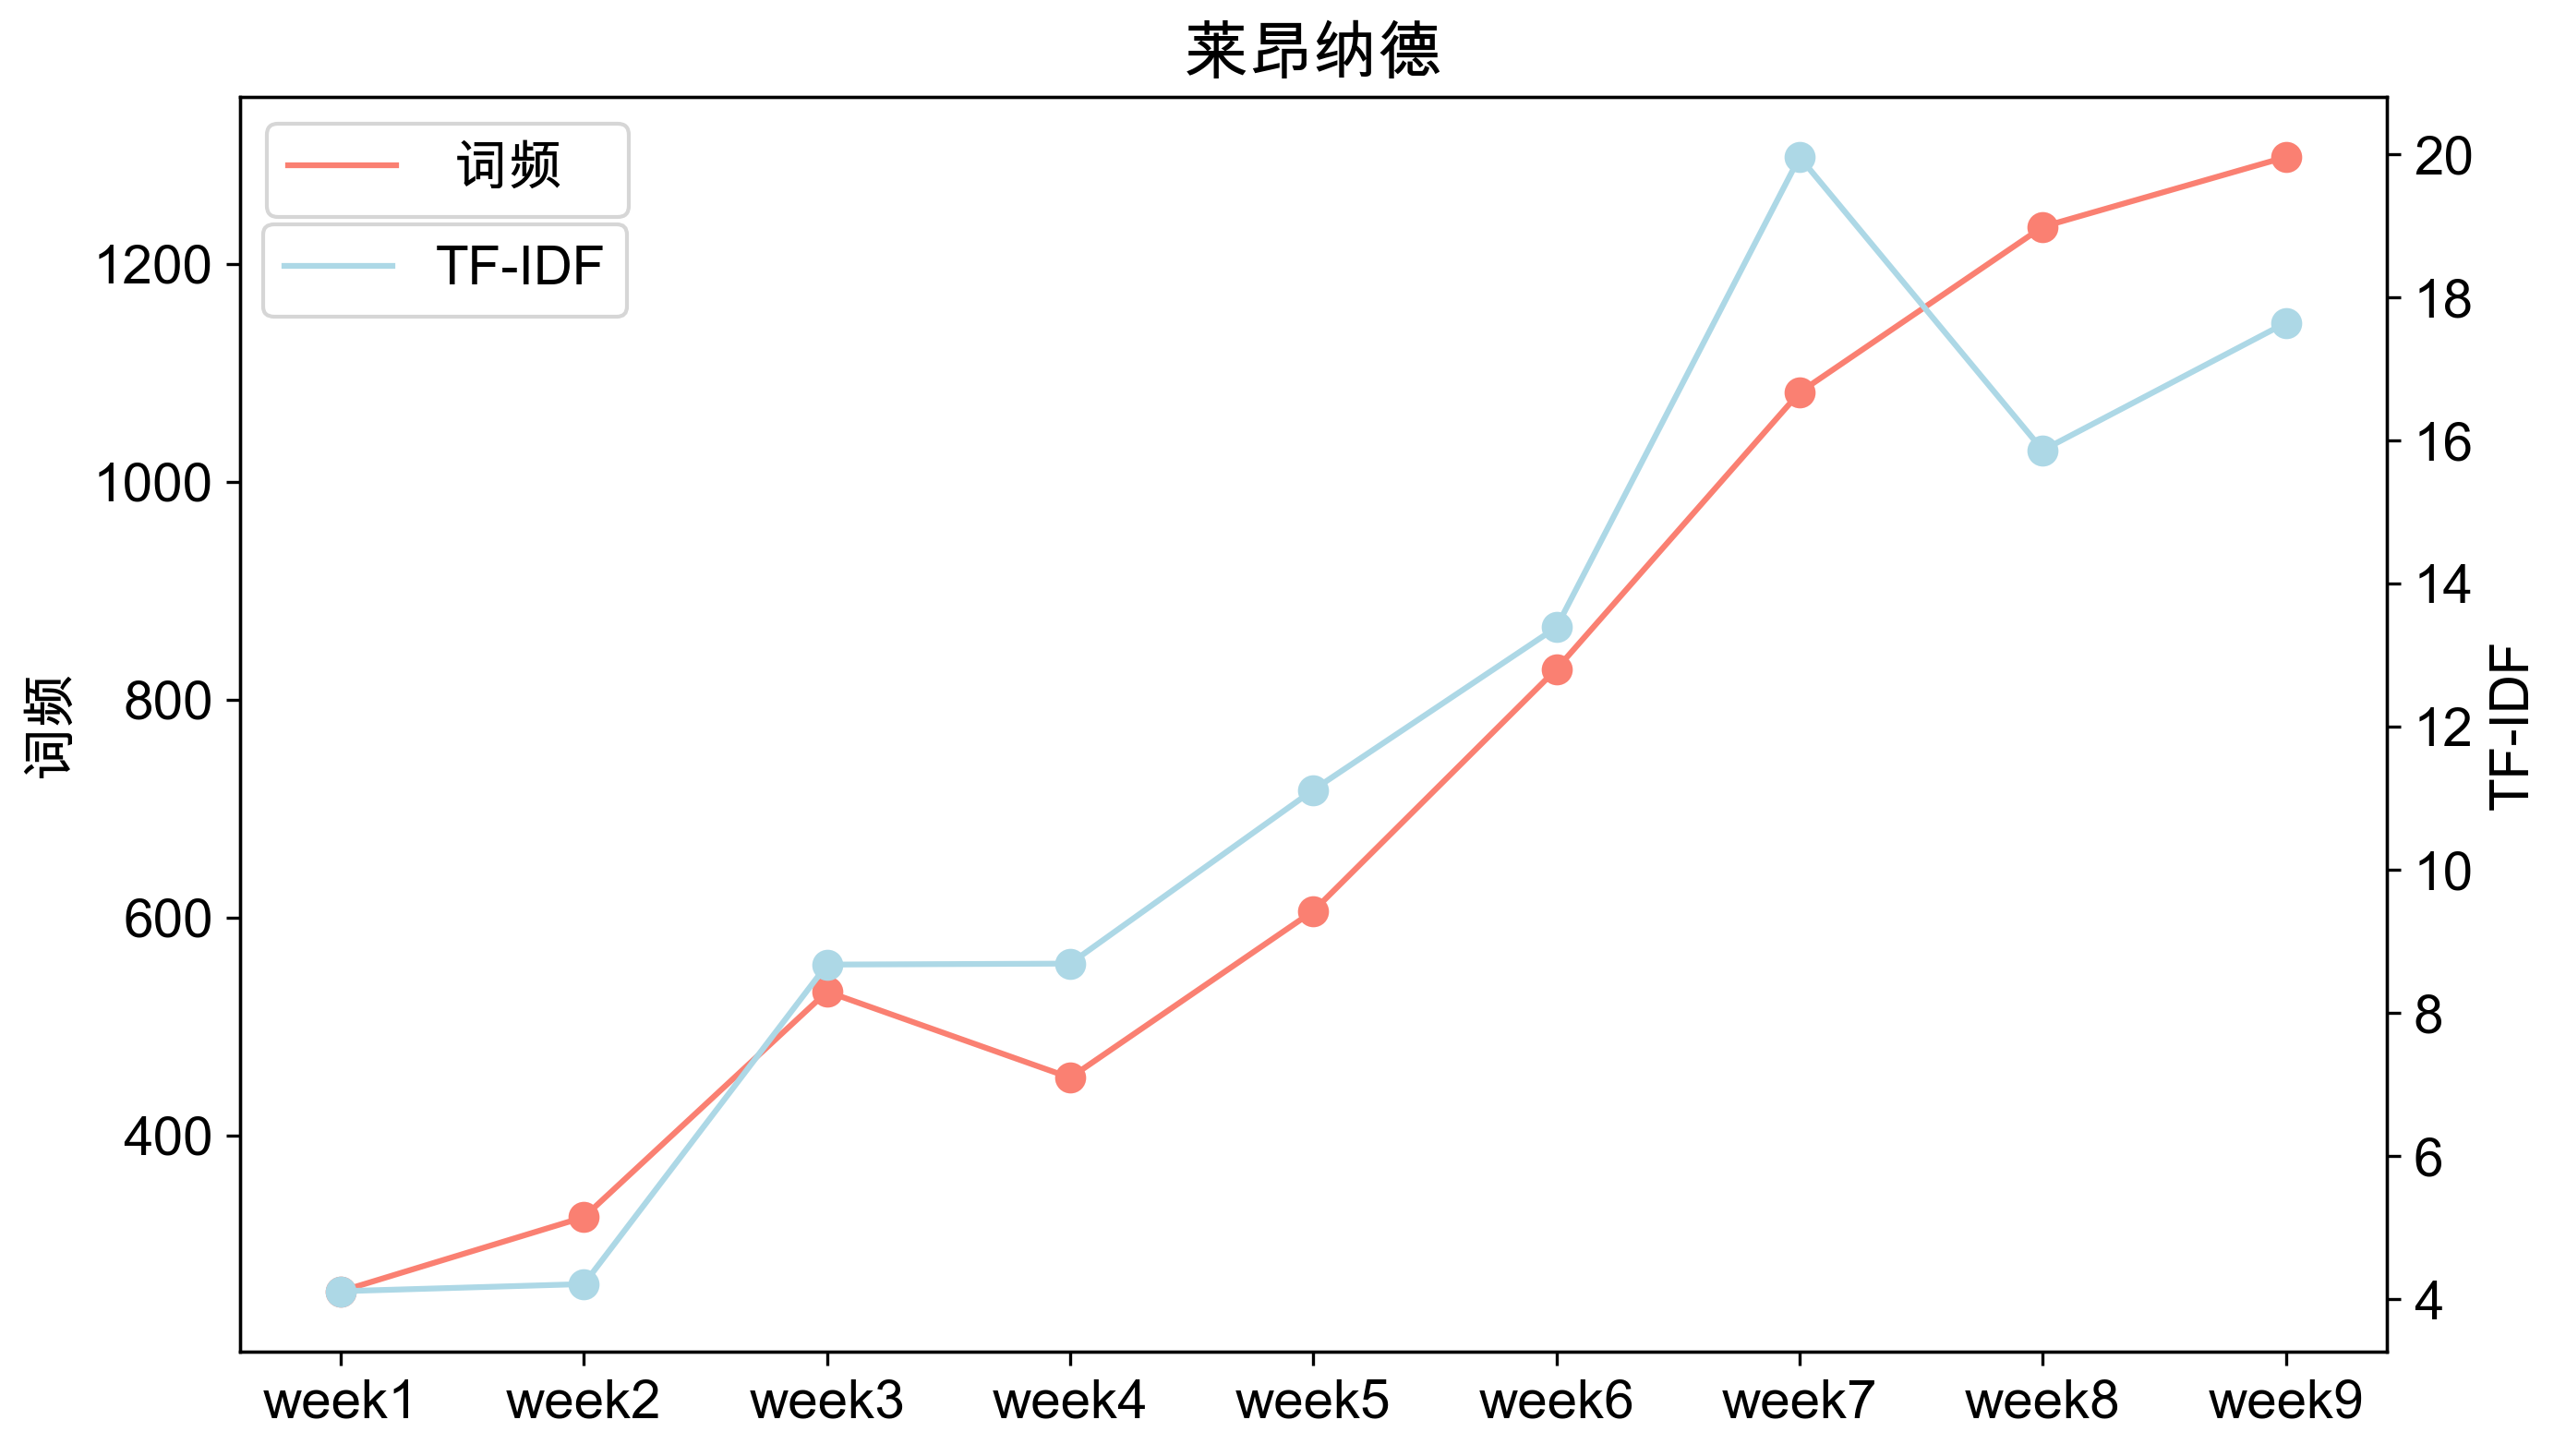

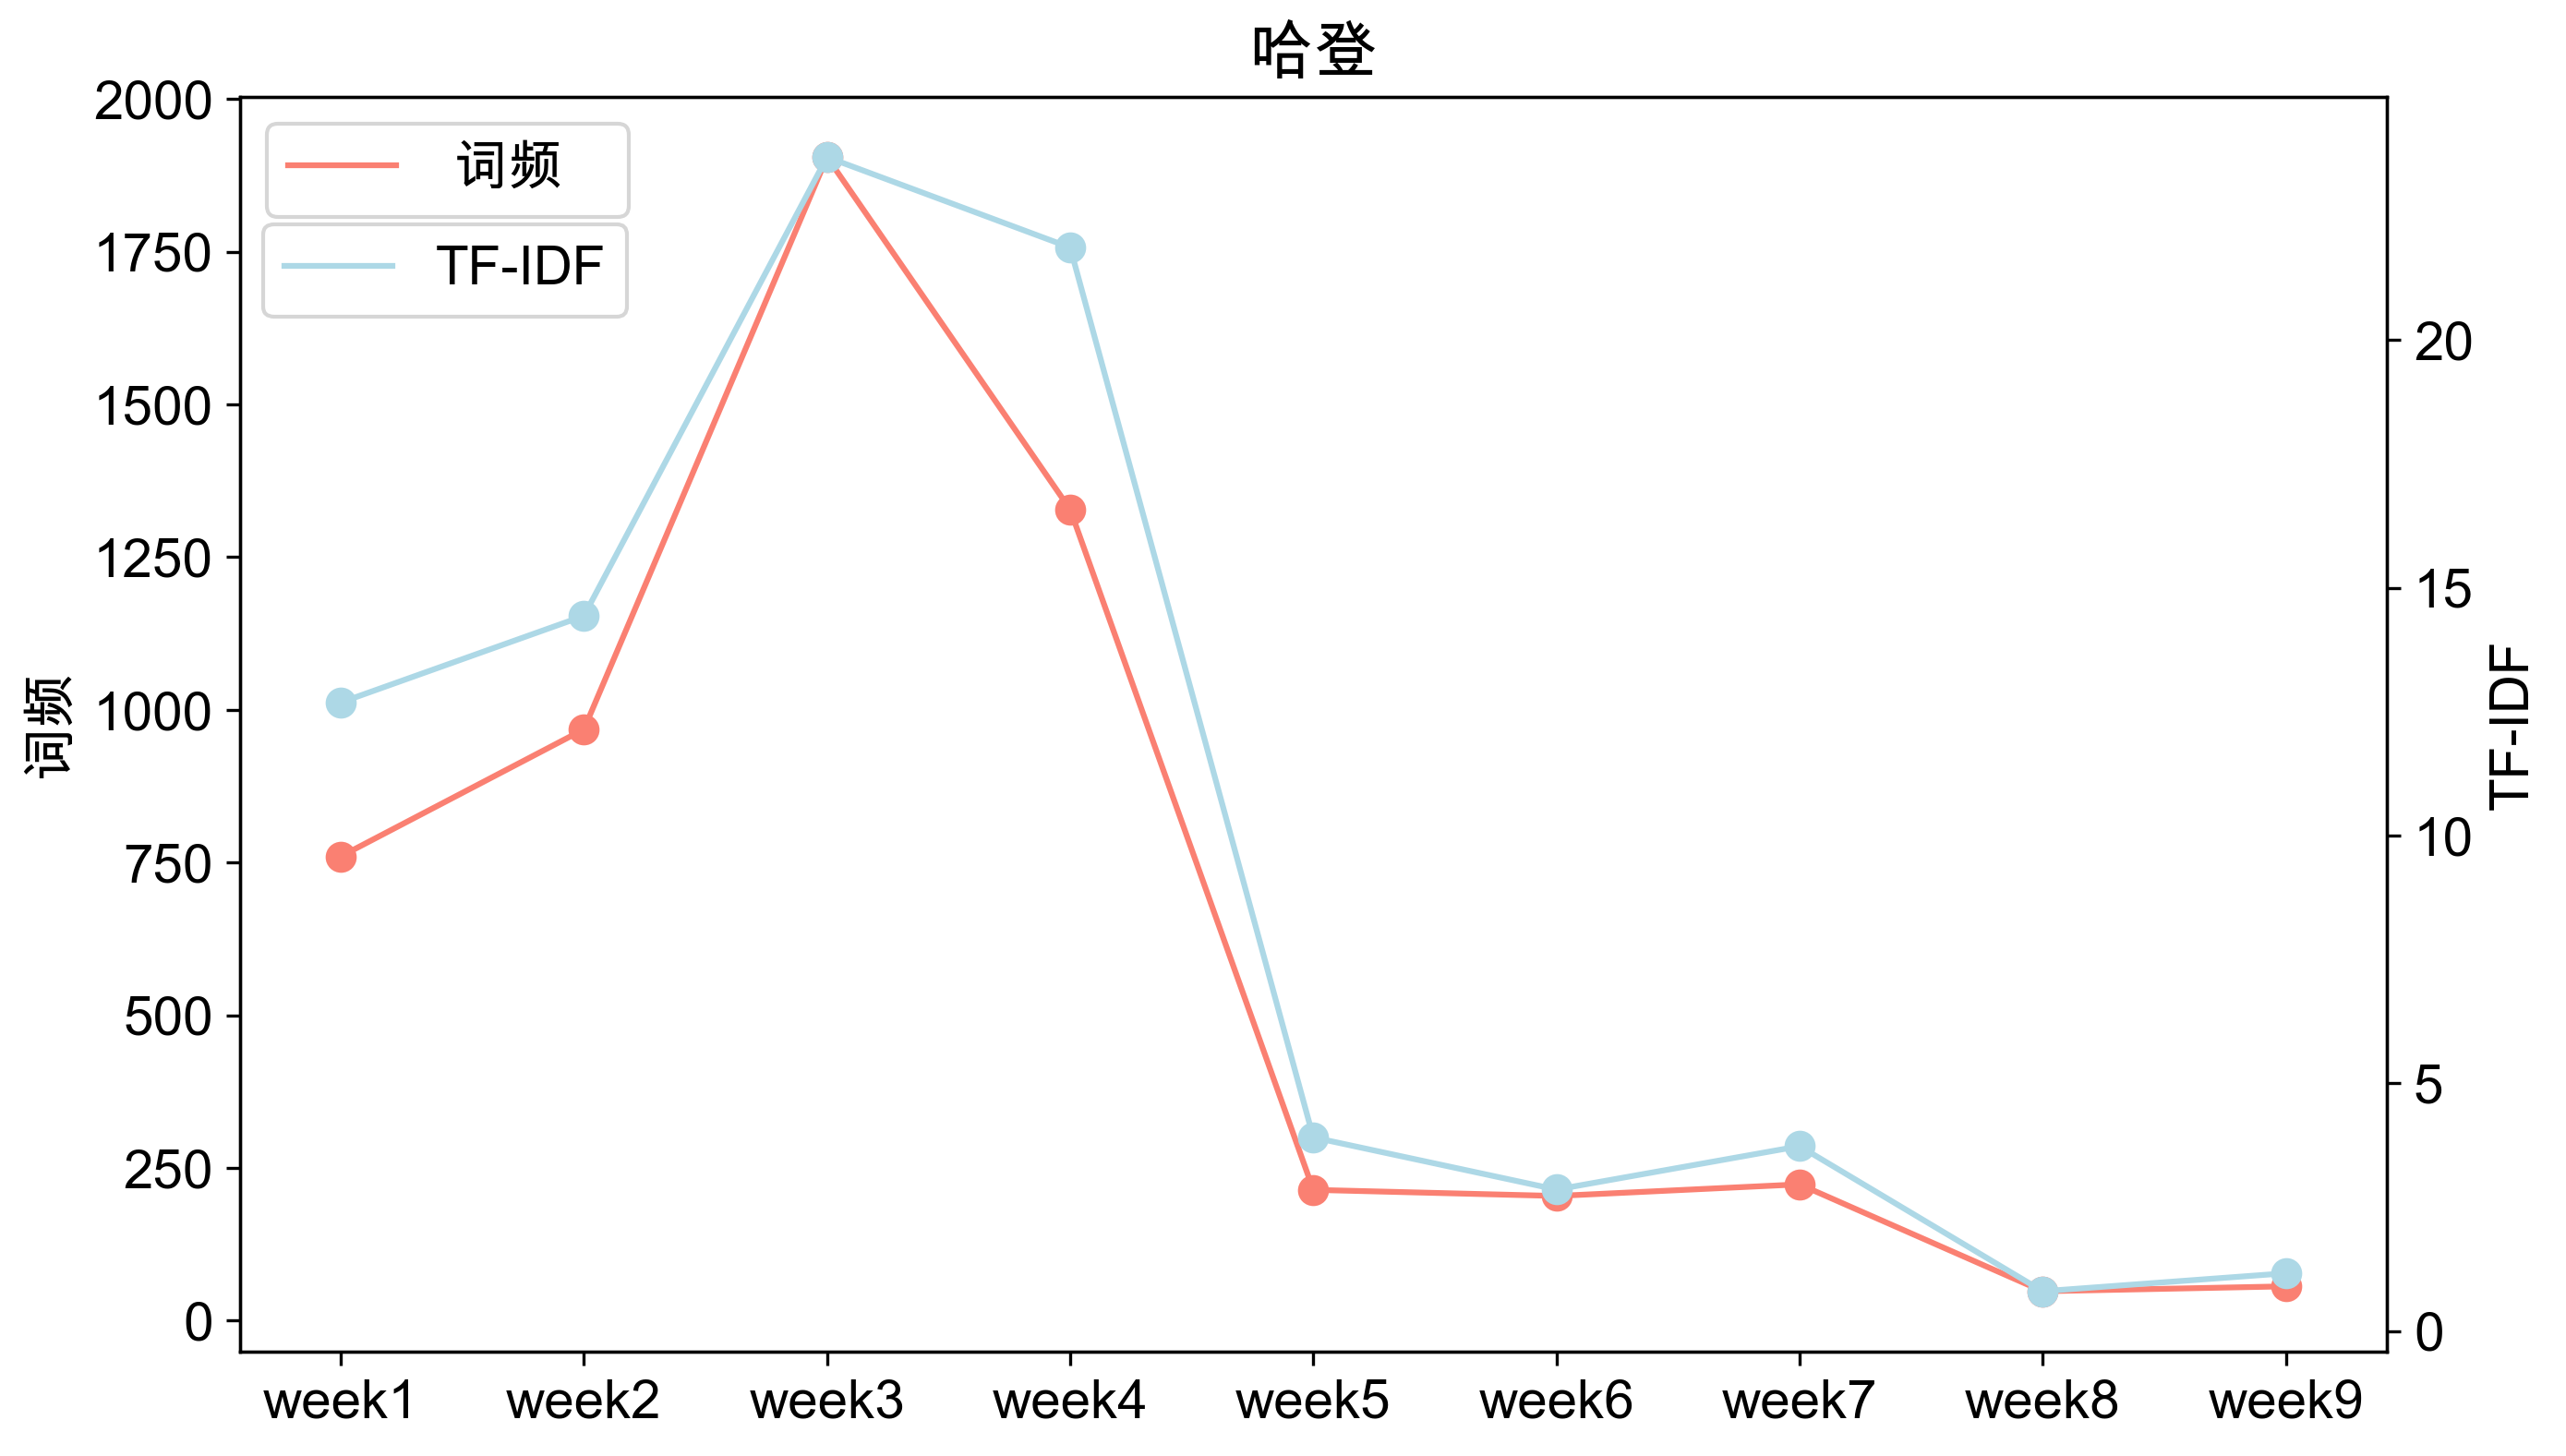

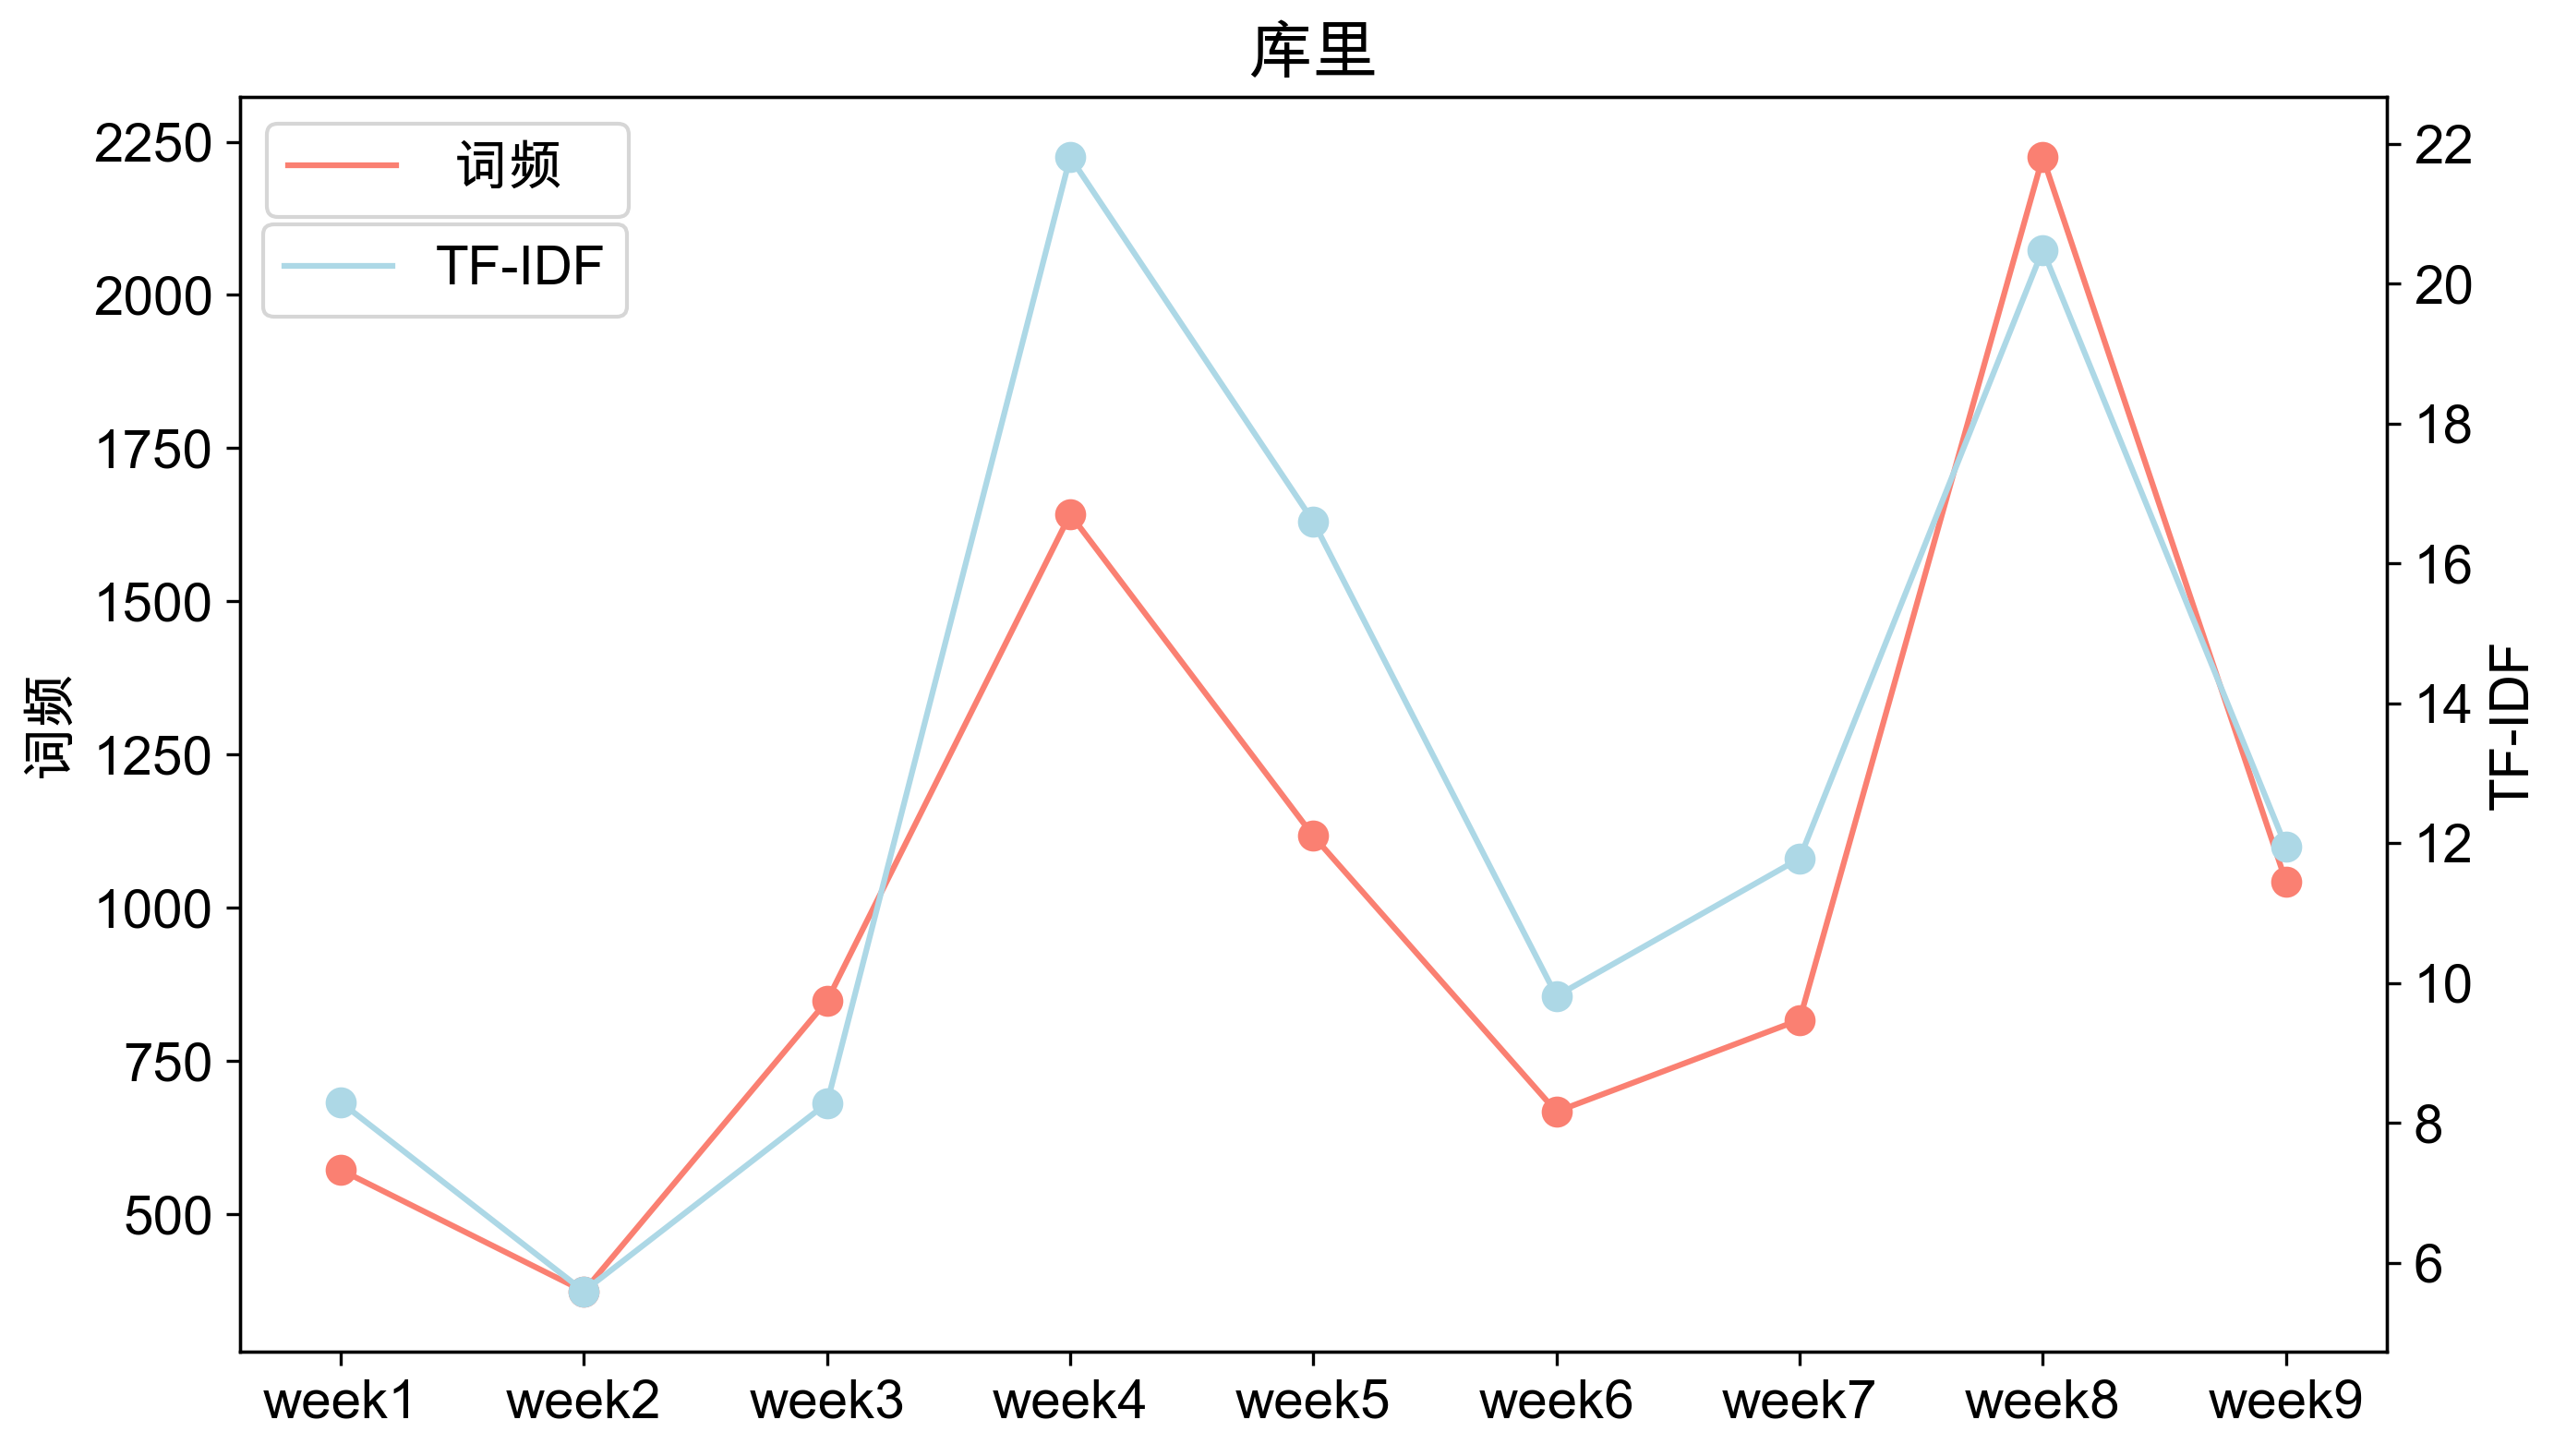

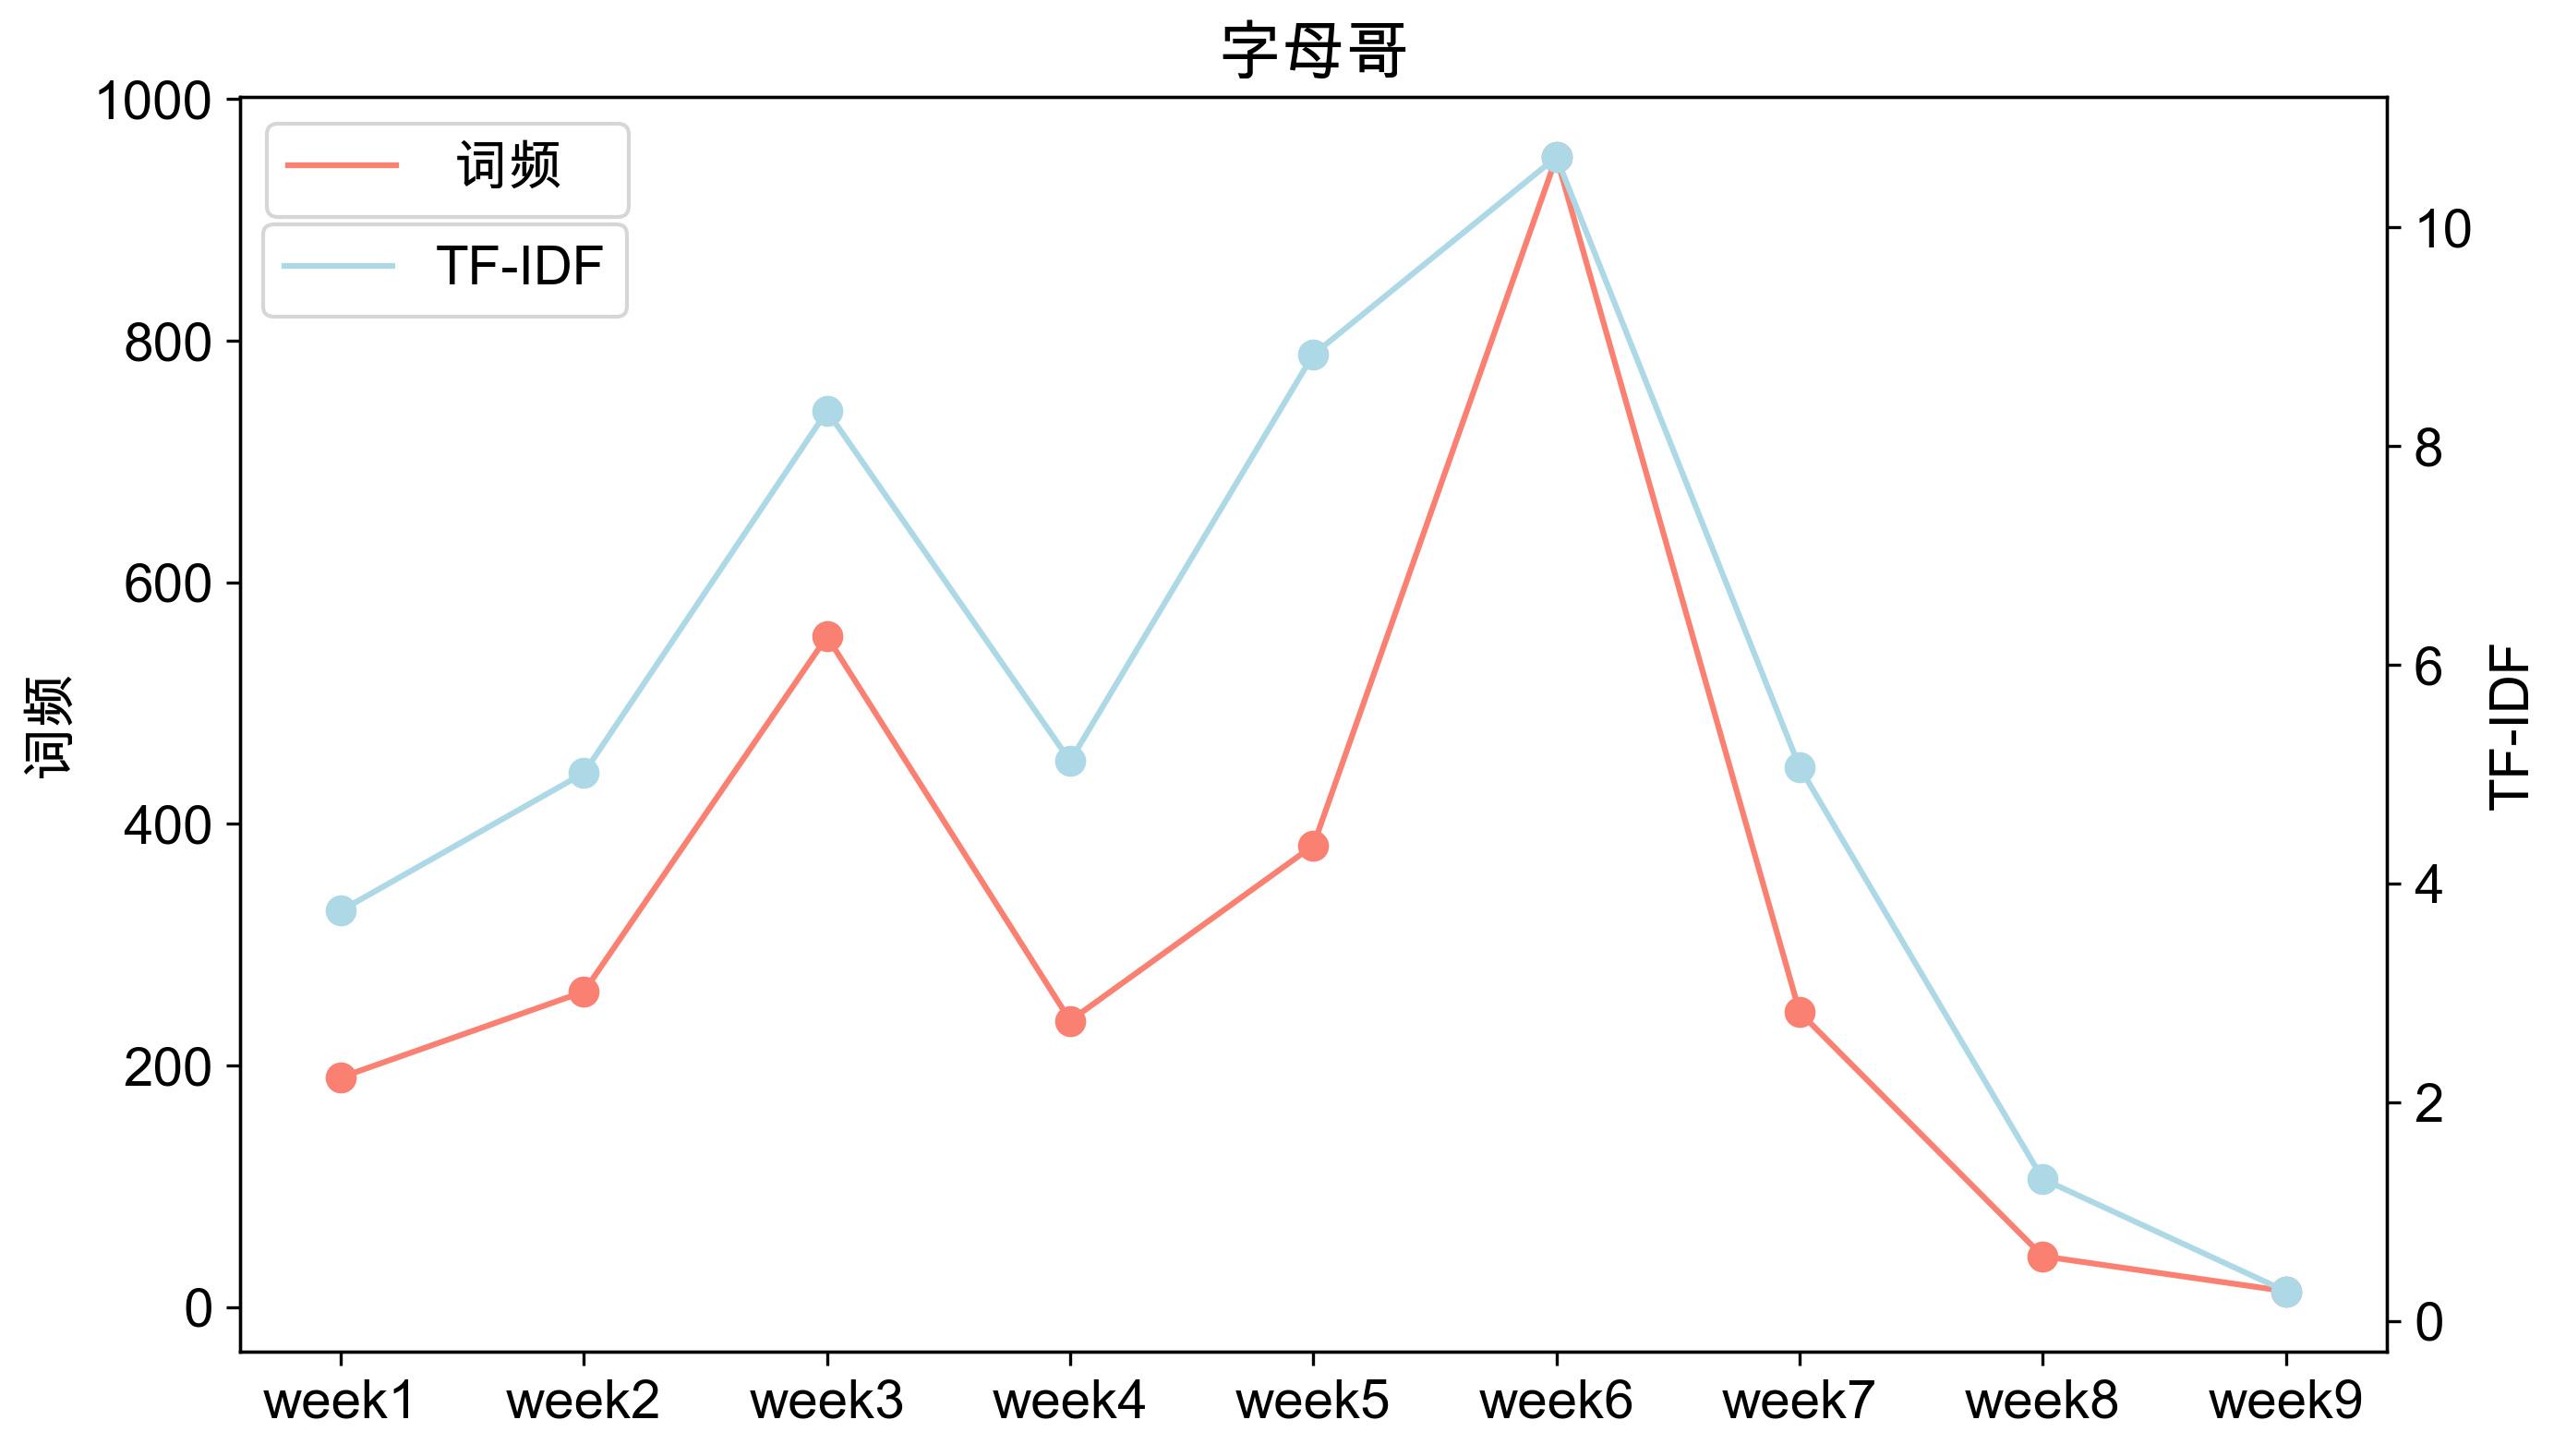

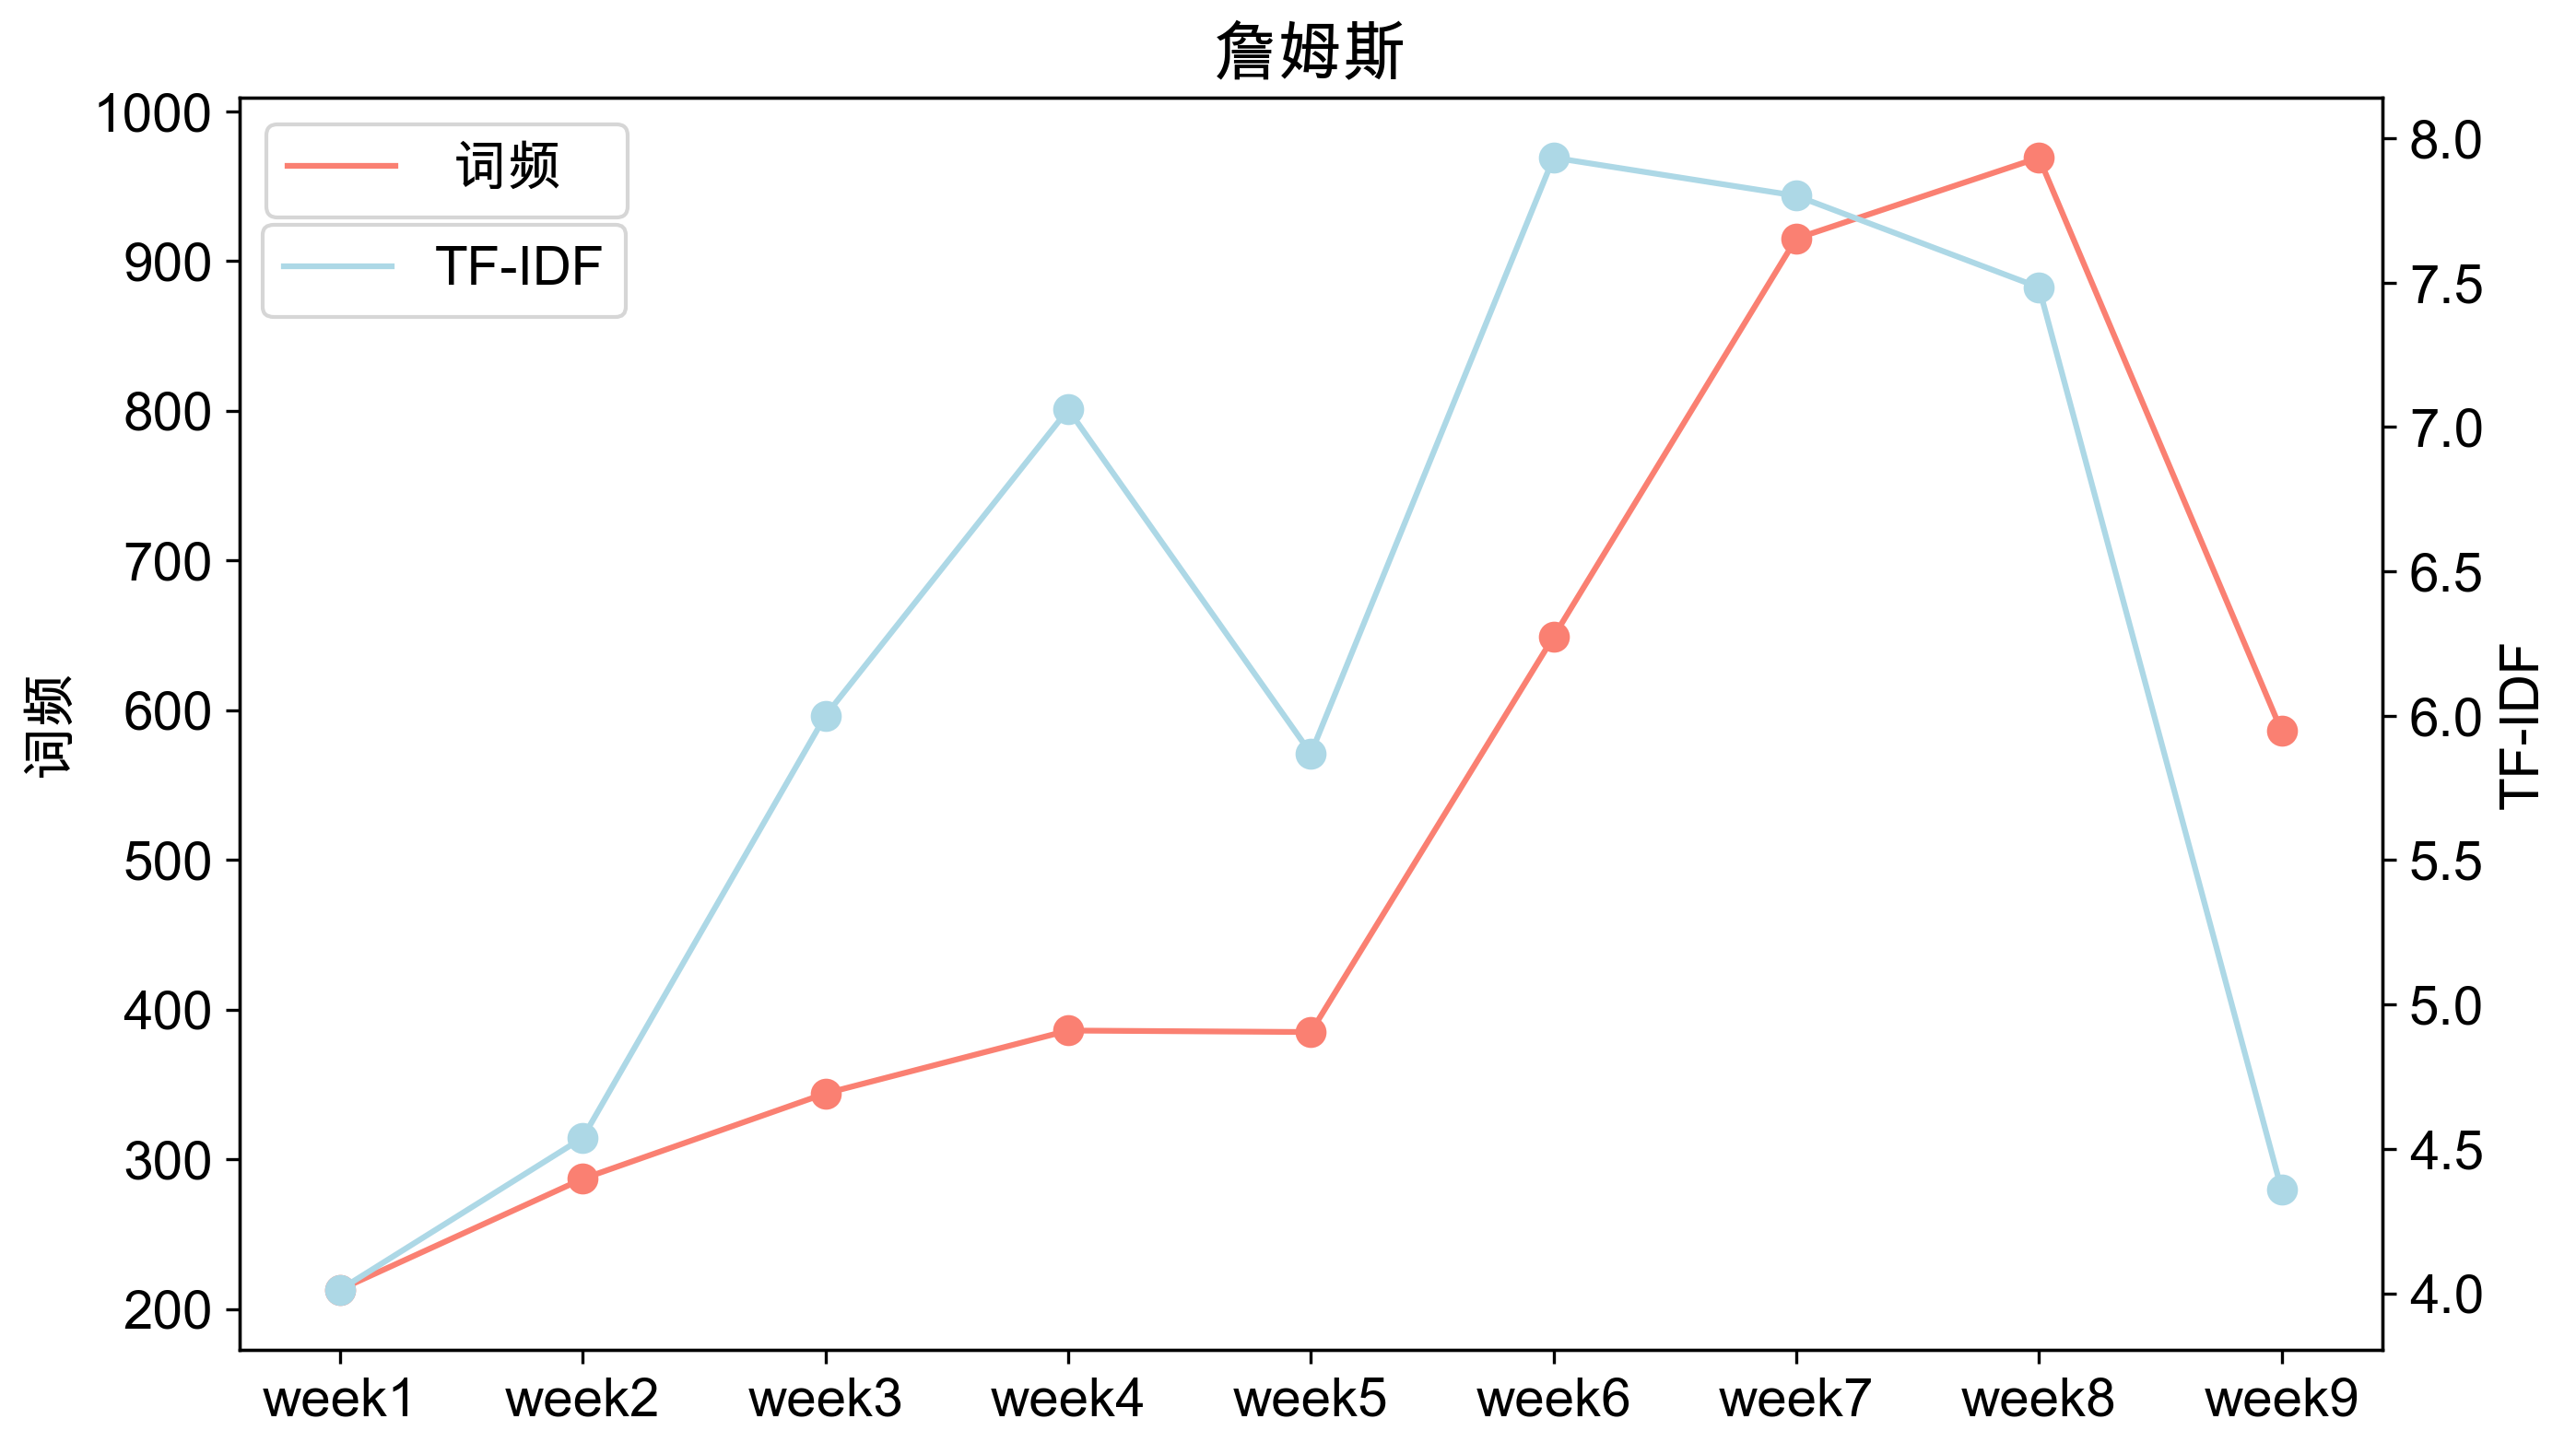

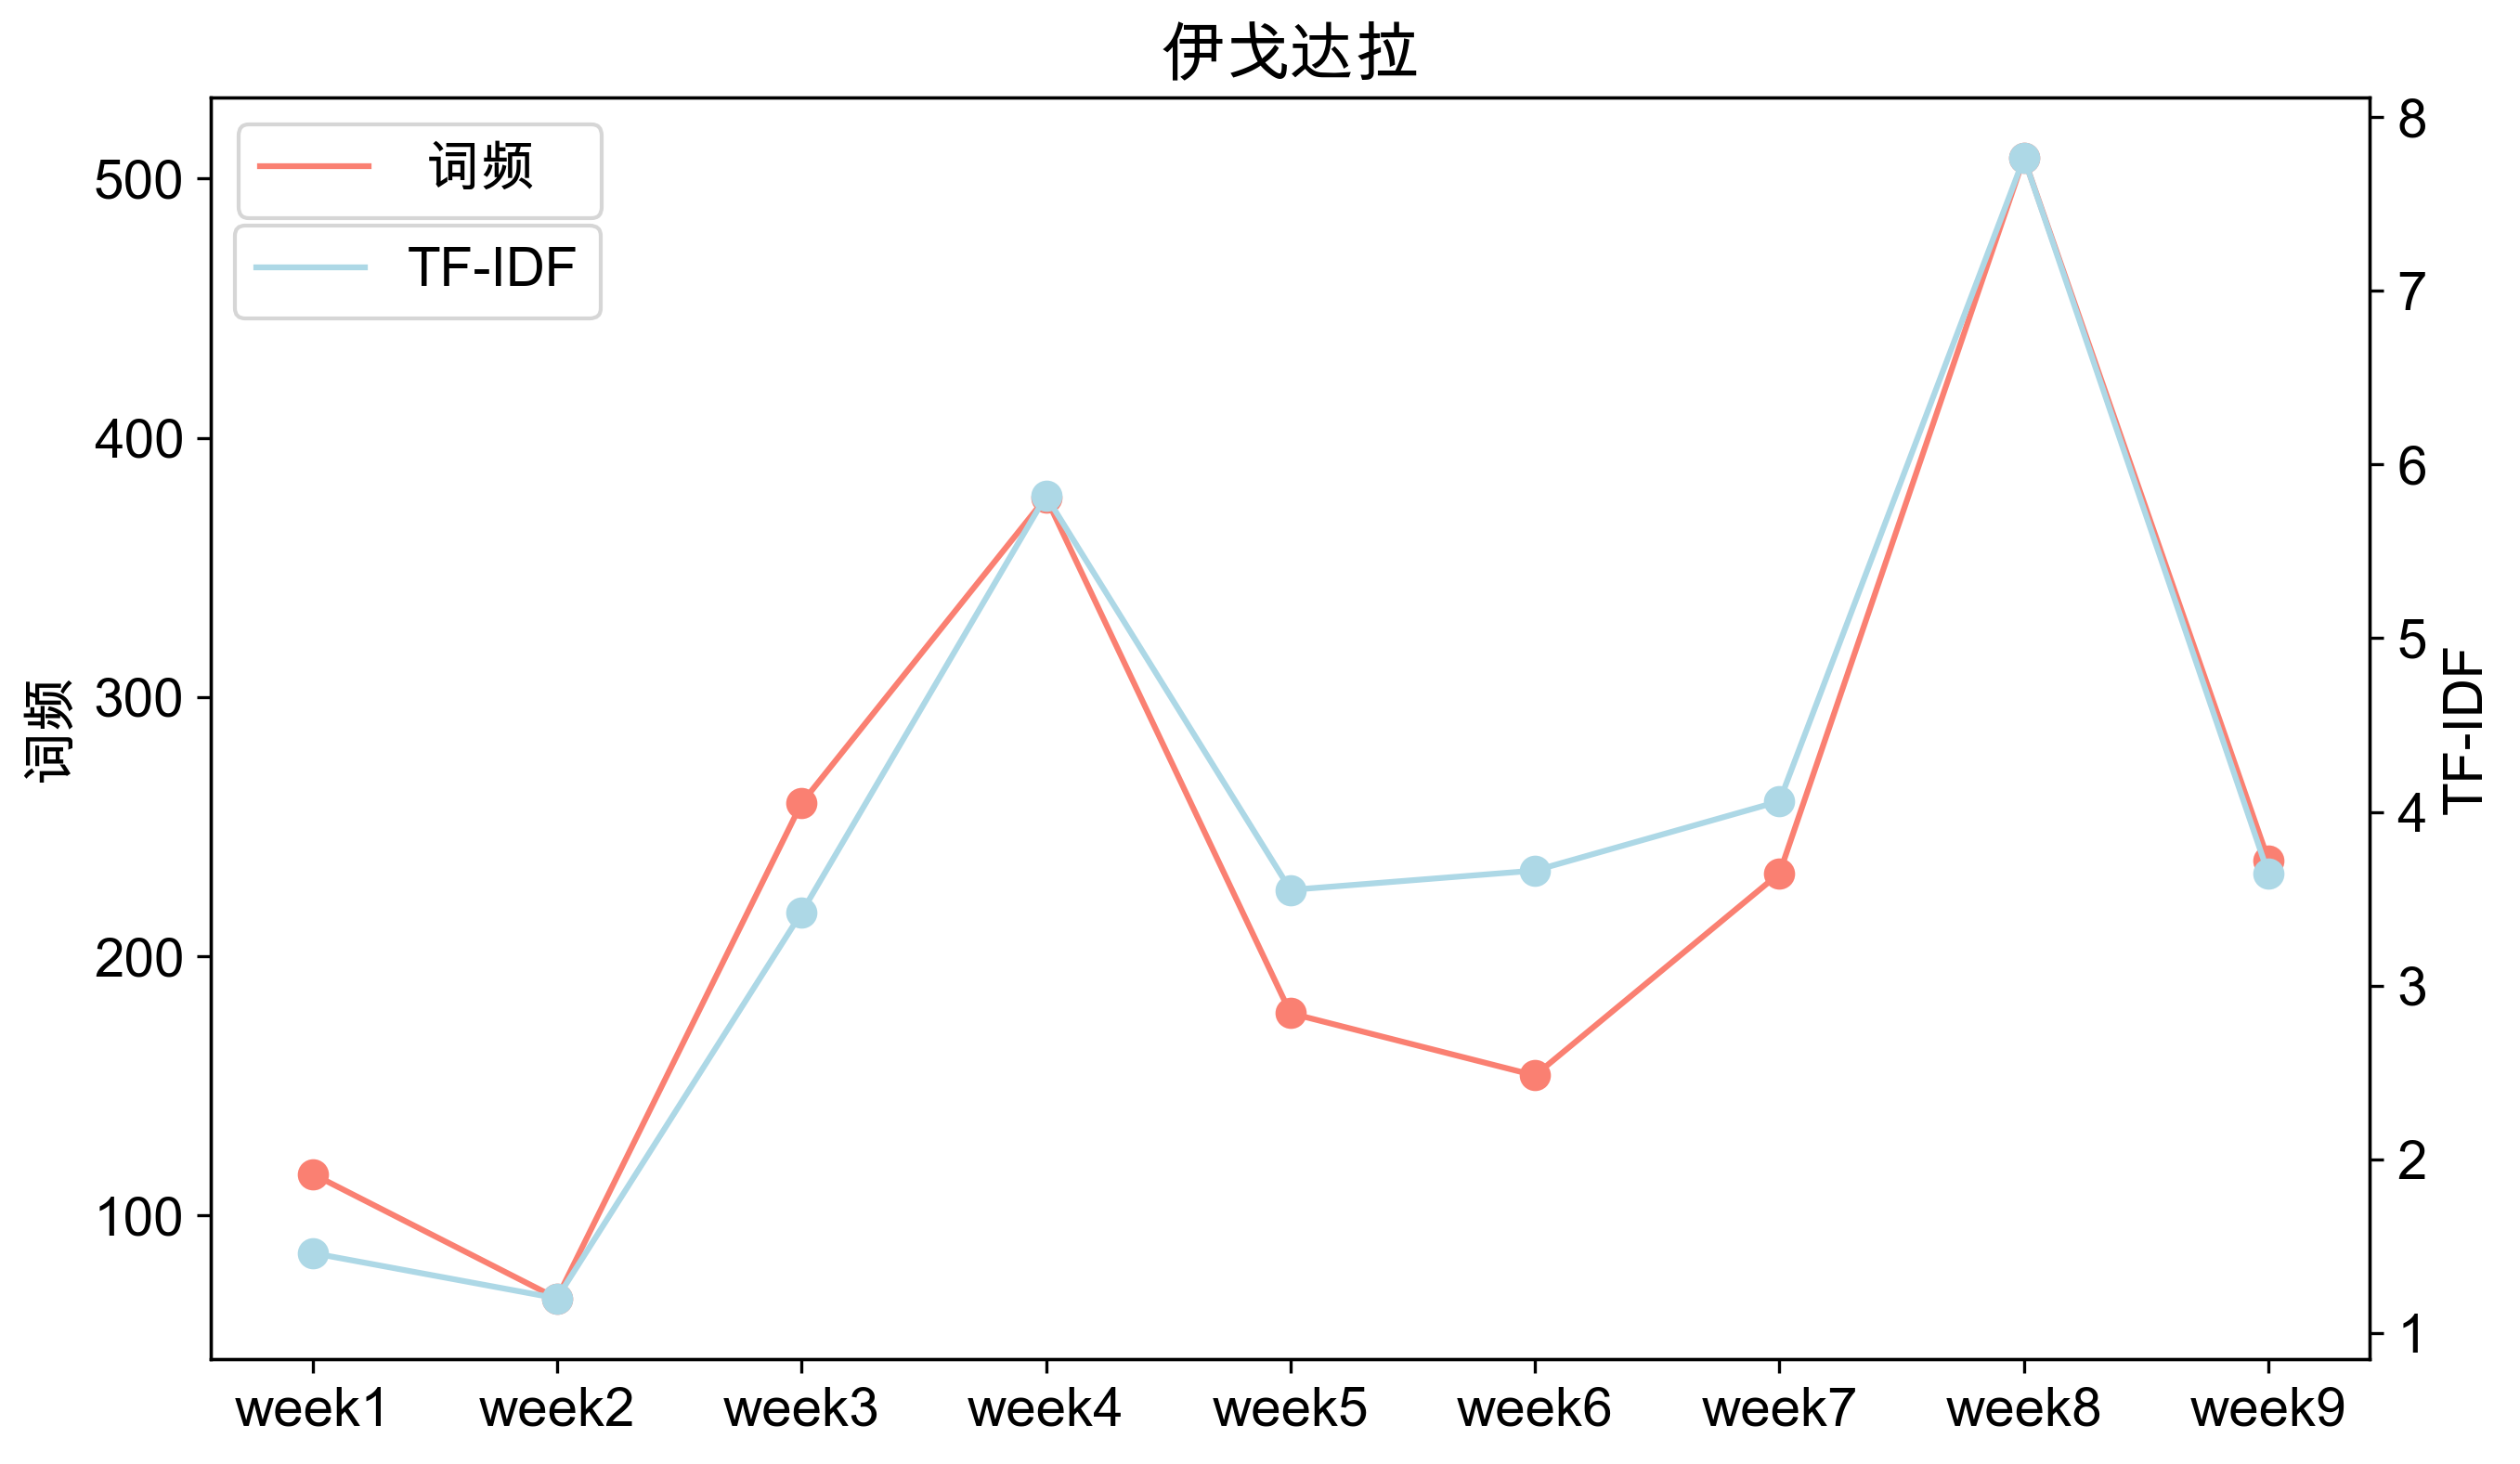

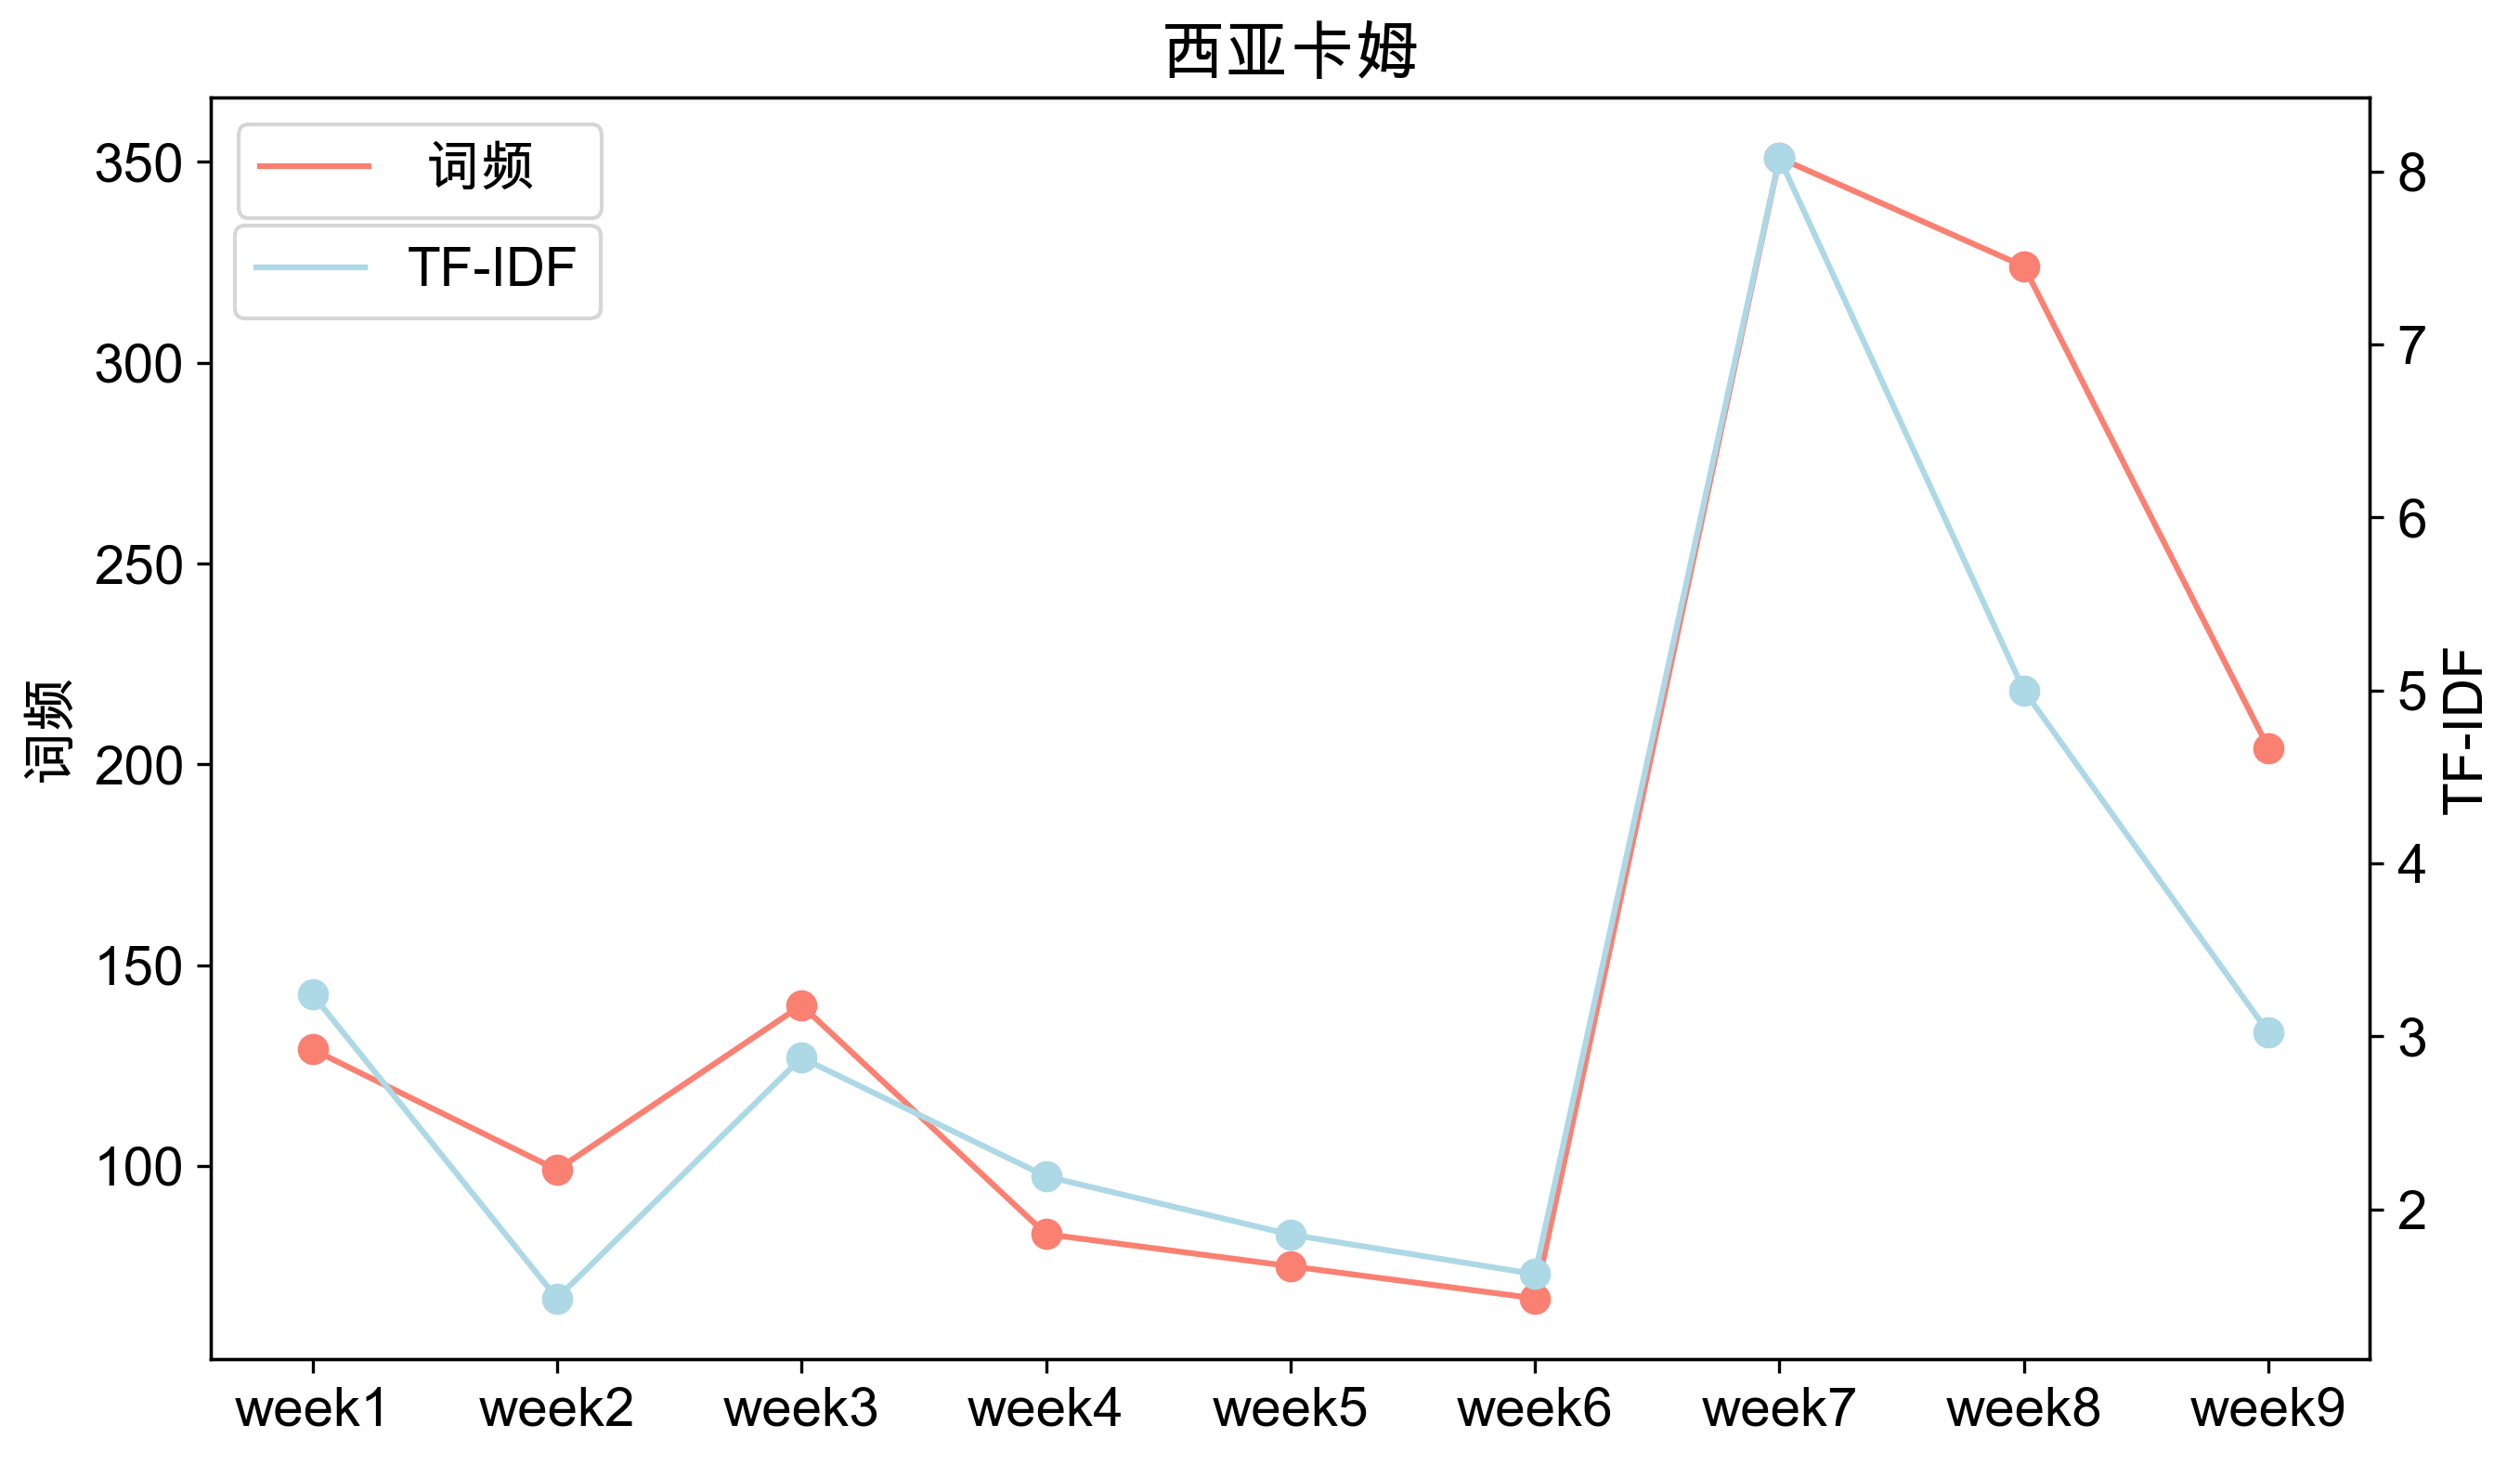

In [58]:
if __name__ == '__main__':
    for name in NBA_player:
        plot_frequence_tfidf(name, Frequence, Tfidf)

+ 分析

###  话题模型

+ NMF、LDA两种方法对整体新闻的话题模型

In [285]:
##NMF
def Word_frequence(documents, method='NMF', max_df=0.95, min_df=2, max_features=1000):
    """
    Use NMF or LDA to get the tf or tfidf and feature_names.
    param:
        documents: input data of segment words.
        method: NMF or LDA.
        max_df,  max_features: param of TfidfVectorizer() or CountVectorizer().
    return:
        if method is NMF, then return tfidf and tfidf_feature_names of each words. Otherwise, return tf, tf_feature_names of each words.
    """
    if method == 'NMF':
        # NMF is able to use tf-idf
        tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, stop_words='english')
        tfidf = tfidf_vectorizer.fit_transform(documents)
        tfidf_feature_names = tfidf_vectorizer.get_feature_names()
        return tfidf, tfidf_feature_names
    elif method == 'LDA':
        # LDA can only use raw term counts for LDA because it is a probabilistic graphical model
        tf_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, stop_words='english')
        tf = tf_vectorizer.fit_transform(documents)
        tf_feature_names = tf_vectorizer.get_feature_names()
        return tf, tf_feature_names
    else:
        print('Method Input Error!')

        
def Model(method = 'NMF', tf_idf=None, no_topics=10):
    """
    train model.
    params:
        if method = 'NMF', tf_idf should be the tfidf. Otherwise, tf_idf is the tf.
    return:
        model of NMF or LDA.
    """
    
    if method == 'NMF':
        return NMF(n_components=no_topics, 
                   random_state=1, 
                   alpha=.1,
                   l1_ratio=.5, 
                   init='nndsvd').fit(tf_idf)
    
    elif method == 'LDA':
        return LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0).fit(tf_idf)
    else:
        print('Method Input Error!')


def display_topics(model, feature_names, no_top_words=10):
    """
    show topics of model.
    params:
        model: NMF or LDA.
        feature_names: the result of Word_frequence.
        no_top_words: number of topic words.
    return:
        None.
    """
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx + 1))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def main(df, no_topics=10, no_top_words=10):
    """
    To show the result of topic model.
    params:
        df: df is a list of all the news.
        no_topic: number of topic.
        no_top_words: number of topic words.
    return:
        None.
    """
    for method in ['NMF', 'LDA']:
        print('------'*10)
        print('%s的Topic为：'%(method))
        tfidf, feature_names = Word_frequence(df, method=method, max_features=100)
        model = Model(method=method, tf_idf=tfidf, no_topics=no_topics)
        display_topics(model, feature_names, no_top_words=no_top_words)
    
if __name__ == '__main__':
    main(df_NBA.seg)
    

------------------------------------------------------------
NMF的Topic为：
Topic 1:
勇士 汤普森 格林 总决赛 科尔 考辛斯 快船 伊戈达拉 比赛 系列赛
Topic 2:
猛龙 莱昂纳德 洛瑞 总决赛 雄鹿 比赛 防守 三分 球迷 表现
Topic 3:
火箭 哈登 保罗 爵士 防守 比赛 裁判 系列赛 勇士 三分
Topic 4:
湖人 詹姆斯 合同 媒体 保罗 总冠军 本赛季 记者 选择 日讯
Topic 5:
开拓者 拉德 掘金 雷霆 比赛 马刺 穆雷 系列赛 三分 西部
Topic 6:
杜兰特 受伤 勇士 勇士队 科尔 比赛 媒体 情况 接受 总决赛
Topic 7:
库里 三分 格林 比赛 汤普森 勇士队 防守 命中 三分球 犯规
Topic 8:
nba 篮球 比赛 合同 联盟 接受 本赛季 说道 记者 采访
Topic 9:
76 比德 比赛 系列赛 拿到 犯规 表现 主场 三分 进攻
Topic 10:
欧文 凯尔特人 雄鹿 字母哥 比赛 系列赛 三分 防守 命中率 表现
------------------------------------------------------------
LDA的Topic为：
Topic 1:
火箭 哈登 勇士 防守 保罗 爵士 进攻 系列赛 杜兰特 阵容
Topic 2:
凯尔特人 欧文 湖人 合同 詹姆斯 本赛季 雄鹿 选择 日讯 联盟
Topic 3:
nba 球迷 媒体 篮球 联盟 比赛 裁判 记者 时间 采访
Topic 4:
詹姆斯 总决赛 乔丹 历史 nba 比赛 拿到 防守 得分 队友
Topic 5:
三分 勇士 比赛 犯规 汤普森 猛龙 命中 防守 领先 进攻
Topic 6:
库里 格林 勇士 比赛 总决赛 猛龙 系列赛 杜兰特 球迷 防守
Topic 7:
杜兰特 勇士 快船 科尔 考辛斯 受伤 总决赛 汤普森 比赛 勇士队
Topic 8:
猛龙 莱昂纳德 雄鹿 字母哥 防守 进攻 比赛 命中率 洛瑞 表现
Topic 9:
比赛 系列赛 表现 说道 一场 胜利 主场 接受 勇士队 采访
Topic 10:
掘金 开拓者 76 比赛 马刺 拉德 雷霆 穆雷 比德 系列赛


---
+ NMF、LDA两种方法用在每周新闻上的话题模型

In [301]:
#处理数据
if __name__ == '__main__':
    df_NBA_day = df_NBA[['day', 'seg']].groupby('day').sum()
    week = []
    for i in range(1, int(len(df_NBA_day)/7)+1):
        a = 'week' + str(i)
        for j in range(7):
            week.append(a)
    df_NBA_day['week'] = week
#     df_NBA_week = df_NBA_day.groupby('week').sum()
    for i in range(1, 10):
        print( '\n【week%s】'%(i))
        df = df_NBA_day[df_NBA_day.week == 'week' + str(i)]
        main(df.seg, no_topics=2, no_top_words=20)
        print('------'*10)



【week1】
------------------------------------------------------------
NMF的Topic为：
Topic 1:
全新 app 发送 上线 获取 至尊 贺电 扭蛋机 改版 观赛 赠送 专属 甄选 分享 不停 穆雷 直播间 喜悦 两战 未经
Topic 2:
穆雷 路威 首场 巴特勒 波波维奇 哈雷尔 沃顿 40 超越 奥古斯丁 威廉 阿伦 过后 国王 迪克 亚当斯 升至 单节 锡安 转载
------------------------------------------------------------
LDA的Topic为：
Topic 1:
穆雷 未经 追究 授权 转载 稿件 法律责任 全新 app 过后 杰克逊 波波维奇 盖伊 阿德 巴特勒 迈克尔 单节 40 西亚卡姆 马龙
Topic 2:
路威 哈雷尔 沃顿 首场 穆雷 威廉 巴特勒 波波维奇 超越 锡安 奥古斯丁 国王 过后 阿伦 单节 40 升至 马刺队 大帝 两罚
------------------------------------------------------------

【week2】
------------------------------------------------------------
NMF的Topic为：
Topic 1:
比德 戈登 勒姆 麦科 猛龙队 贝瑞 魔术队 巴特勒 亚当斯 赛点 伊巴 塔克 德里 弗格森 海沃德 武切 维奇 纳利 洛瑞 冲突
Topic 2:
路威 威廉姆斯 快船队 哈雷尔 死亡 第六场 考辛斯 穆雷 交手 金州 第六 伊戈达拉 player 策略 合同 克劳德 纳利 万美元 先发 自由
------------------------------------------------------------
LDA的Topic为：
Topic 1:
路威 威廉姆斯 切克 player 穆雷 弗里 哈雷尔 第六场 快船队 考辛斯 死亡 合同 阿德 盖伊 第六 100 纳利 伊戈达拉 万美元 交手
Topic 2:
比德 勒姆 戈登 麦科 亚当斯 巴特勒 猛龙队 弗格森 塔克 魔术队 阿米 赛点 德里 伊巴 维奇 武切 穆雷 冲突 纳利 拉蒙德
----------

### word2vec进行聚类检测
+ 训练模型
+ PCA降维
+ 聚类

In [304]:
###训练模型
if __name__ == '__main__':
    open('NBA_news_reg.txt', 'w+', encoding='utf-8').write(''.join(df_NBA_day.seg))
    word2vec.word2vec('NBA_news_reg.txt', 'NBA_news_word2vec.bin', size = 100, window = 10)

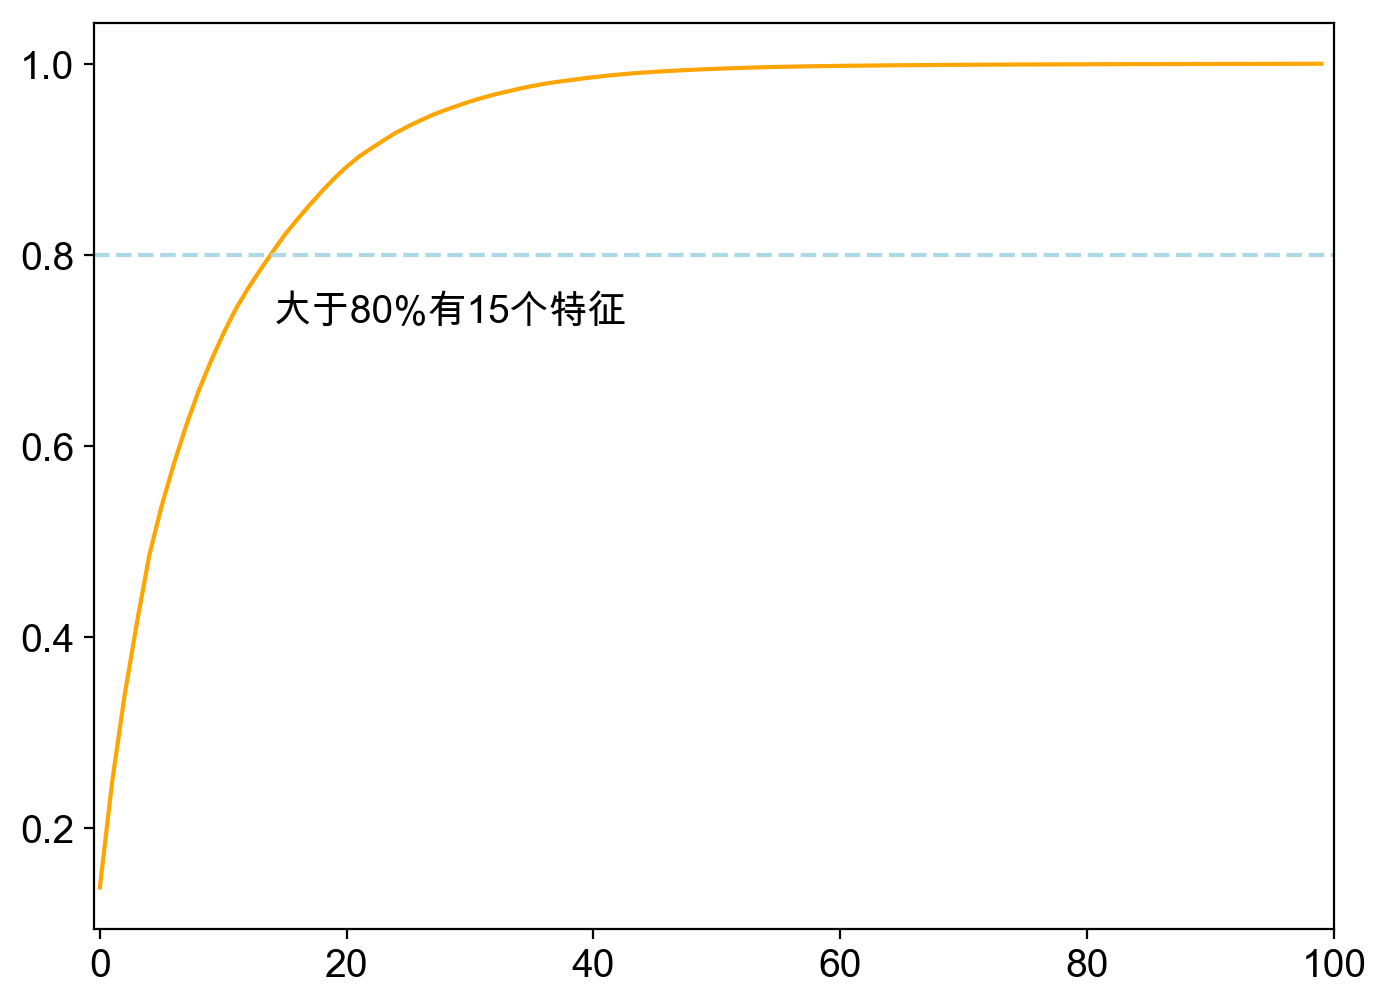

In [480]:
#PCA降维
if __name__ == '__main__':
    NBA_news_model = word2vec.load('NBA_news_word2vec.bin')
    pca = PCA()   
    pca.fit(NBA_news_model.vectors) #训练
    newX=pca.fit_transform(NBA_news_model.vectors)   #降维后的数据
    ratio = pca.explained_variance_ratio_ #方差占比
    fig = plt.figure(figsize=(8, 6))
    plt.plot(ratio.cumsum(), c='orange')
    plt.plot([-.5, 100], [0.8, 0.8], '--', c='lightblue')
    plt.xlim(-.5, 100)
    ###保留>80%的数据
    feature_num = ((ratio.cumsum() < 0.8)).sum() +1 #>80%有15个特征
    plt.text(feature_num - 1, 0.73, '大于80%有15个特征')
    plt.show()
    plt.close()

In [396]:
##PCA聚类结果
if __name__ == '__main__':
    vectors_dimensionality_reduction = newX[:, :feature_num]
    vocabulary = NBA_news_model.vocab

In [437]:
# K-Means聚类， 聚成5类。找到每类词中的关键词，用词频衡量。
def K_means_cluster(n_clusters=5, top_words_num=20):
    """
    K-means clustering.
    params:
        n_clusters:  number of clusters.
        top_words_num: number of showing words.
    return:
        None.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(vectors_dimensionality_reduction)
    cluster_label = kmeans.labels_  #聚类结果
    print('K-means共聚成%s类：'%(n_clusters))
    frequence_all_words = re.split(' ', ' '.join(df_NBA.seg))
    for i in range(n_clusters):
        vocab_i = vocabulary[cluster_label == i].tolist() #第i类的词
        #第i类词的词频的前20个词
        word_count_20 = {}
        for word in vocab_i:
            word_count_20[word] = frequence_all_words.count(word)
        word_20 = sorted(word_count_20, key=lambda x: word_count_20[x], reverse=True)[:top_words_num] #降序排列，前20个
        print('第%s类的前%s个关键词为：\n\t%s'%(i + 1, top_words_num, ' '.join(word_20)))
        
if __name__ == '__main__':
    K_means_cluster()

K-means共聚成5类：
第1类的前20个关键词为：
	比赛 勇士 杜兰特 猛龙 库里 火箭 三分 总决赛 莱昂纳德 系列赛 表现 詹姆斯 拿到 开拓者 雄鹿 时间 命中率 汤普森 76 掘金
第2类的前20个关键词为：
	防守 哈登 进攻 格林 投篮 阵容 对手 能力 队友 伊戈达拉 犯规 考辛斯 面对 出手 突破 选择 裁判 出色 战术 西亚卡姆
第3类的前20个关键词为：
	助威 全新 App 专属 发送 会员 直播间 互动 观赛 掌擂 上线 喜悦 专享 获取 至尊 贺电 扭蛋机 赠送 改版 甄选
第4类的前20个关键词为：
	球迷 科尔 媒体 接受 说道 采访 事情 记者 赛后 社交 想要 回到 训练 努力 打球 做出 真的 喜欢 发生 离开
第5类的前20个关键词为：
	NBA 联盟 湖人 篮球 球星 合同 教练 交易 主帅 拥有 安东尼 科比 冠军 主教练 报道 一位 一支 一名 美国 魔术师


+ 分析

In [483]:
frequence.to_csv('球队球员词频.csv', index=True, encoding='utf-8')

##  季后赛球队球员表现

In [487]:
tfidf.to_csv('球队球员tfidf.csv', index=True, encoding='utf-8')

In [ ]:
##word2vec数据：
#重新降维一下
#PCA降维
if __name__ == '__main__':
    NBA_news_model = word2vec.load('NBA_news_word2vec.bin')
    pca = PCA()   
    pca.fit(NBA_news_model.vectors) #训练
    newX=pca.fit_transform(NBA_news_model.vectors)   #降维后的数据
    ratio = pca.explained_variance_ratio_ #方差占比
    feature_num = ((ratio.cumsum() < 0.8)).sum() +1 #>80%有15个特征

In [16]:
frequence = pd.read_csv('球队球员词频.csv')
tfidf = pd.read_csv('球队球员tfidf.csv')
Frequence = frequence.groupby('week').sum()
Tfidf = tfidf.groupby('week').sum()